In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import NuestrasFunciones

import statsmodels.api as sm 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")


In [154]:
df_titanic_train = pd.read_csv("Out/df_imputed_transformed_train.csv", index_col = 0)
df_titanic_test = pd.read_csv("Out/df_imputed_transformed_test.csv", index_col = 0)

to_factor = list(df_titanic_train.loc[:,df_titanic_train.nunique() <= 4]);  
df_titanic_train[to_factor] = df_titanic_train[to_factor].astype('category')
df_titanic_train["Embarked_Rank"] = df_titanic_train["Embarked_Rank"].astype('int')

to_factor = list(df_titanic_test.loc[:,df_titanic_test.nunique() <= 4]);  
df_titanic_test[to_factor] = df_titanic_test[to_factor].astype('category')
df_titanic_test["Embarked_Rank"] = df_titanic_test["Embarked_Rank"].astype('int')

In [3]:
df_titanic_train.Cabin_Letra_Rank.describe()

count    891.000000
mean       3.177329
std        2.188320
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        9.000000
Name: Cabin_Letra_Rank, dtype: float64

### Guianza en este punto sería de mucha ayuda. Pudiese hacer el siguiente split antes o después de pasar los datos crudos por mi pipeline, haciendo que el test set sólo haga transform pero no fit. Sin embargo, dado el pequeño tamaño muestral de algunas categorías, pienso que así es mejor.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, test_index in spliter.split(df_titanic_train, df_titanic_train["Survived"]):
        train_set = df_titanic_train.loc[train_index].reset_index().drop("index",axis = 1)
        test_set = df_titanic_train.loc[test_index].reset_index().drop("index",axis = 1)


Y_train = train_set.Survived
X_train = train_set.drop(["Survived","PassengerId","Embarked"],axis = 1).select_dtypes(exclude = "object")

Y_test = test_set.Survived
X_test= test_set.drop(["Survived","PassengerId","Embarked"],axis = 1).select_dtypes(exclude = "object")

In [5]:
#Y_train = train_set.Survived
Y_train

0      0
1      0
2      0
3      0
4      0
      ..
707    0
708    1
709    0
710    0
711    1
Name: Survived, Length: 712, dtype: category
Categories (2, int64): [0, 1]

<Axes: >

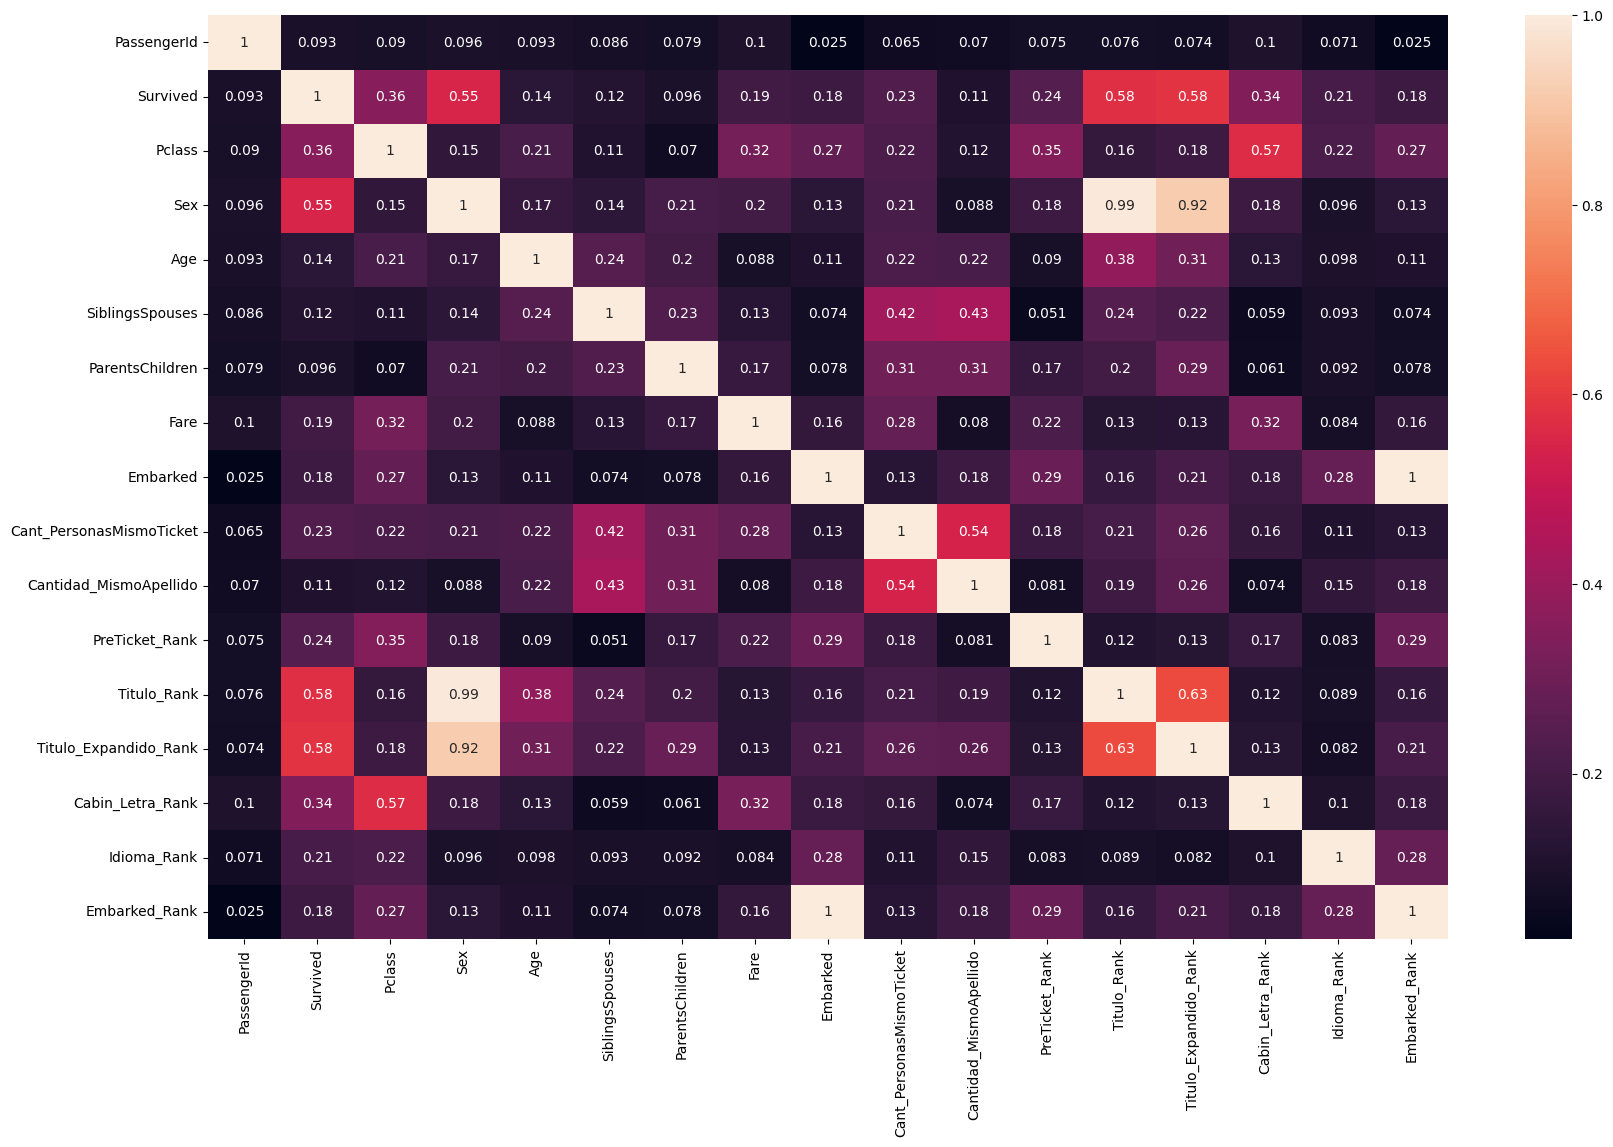

In [6]:
corr = NuestrasFunciones.get_cat_corr_mat(train_set)
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

#### De la matriz de asociación de Cramer podemos sacar muchas conclusiones.
- Nuestros Ranks según título están enormemente correlacionados con el género, parece que el poder de asociación de estos ranks con "Survived" es sólo un poco mayor que el de género.
- Obviamente las variables SiblingSpouse y ParentChildren se correlacionan mucho con cantidad de personas mismo ticket / mismo apellido.
- Tenemos una idea primeriza de cuáles serán nuestros features a utilizar en el modelo.

## Buscaremos ahora transformaciones de nuestras variables continuas que tengan mayor asociación con la objetivo 

In [7]:
def transf_test(df, ser):

    if not isinstance(ser, pd.Series):
        raise ValueError("El input debe ser el df a transformar y el resultado de llamar mejorTransf(name = True).")
        
    for i in ser.values:
        #vv = pd.Series(scale(i), name=i.name)
        #print(vv)
        columna,transformacion = i.split("-")
        
        if transformacion == "ident":
            pass
        elif transformacion == "log":
            df[columna + "-" + transformacion] = np.log(df[columna])
        elif transformacion == "exp":
            df[columna + "-" + transformacion] = np.exp(df[columna])
        elif transformacion == "sqrt":
            df[columna + "-" + transformacion] = np.square(df[columna])
        elif transformacion == "cuarta":
            df[columna + "-" + transformacion] = df[columna]**4
        elif transformacion == "raiz4":
            df[columna + "-" + transformacion] = df[columna]**1/4
            
    return df



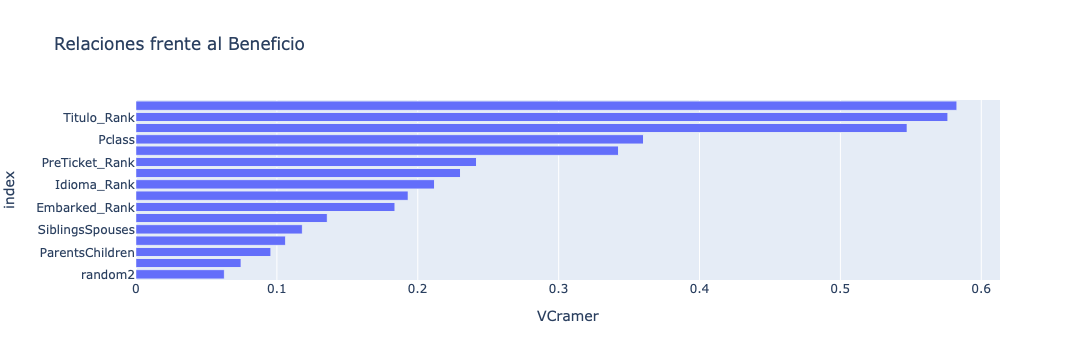

In [8]:
X_train["random"] = np.random.uniform(0,1, size=X_train.shape[0])
X_train["random2"] = np.random.uniform(0,1, size=X_train.shape[0])

tablaCramer = pd.DataFrame(X_train.apply(lambda x: NuestrasFunciones.cramers_v(x,Y_train)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al Beneficio').update_yaxes(categoryorder="total ascending")




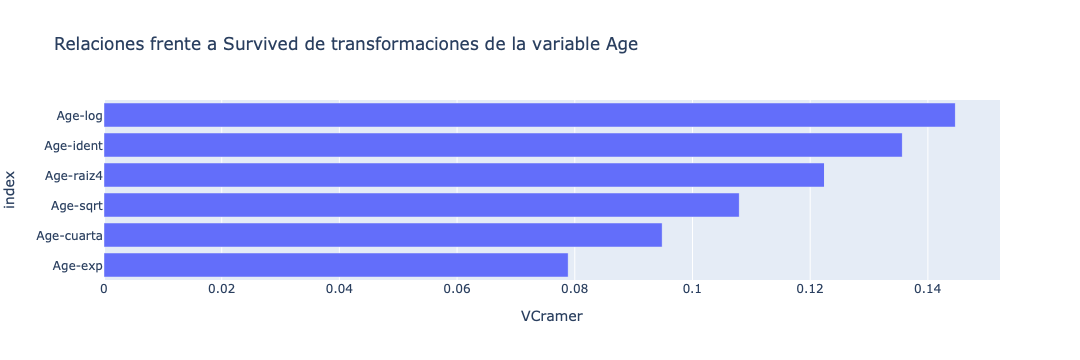

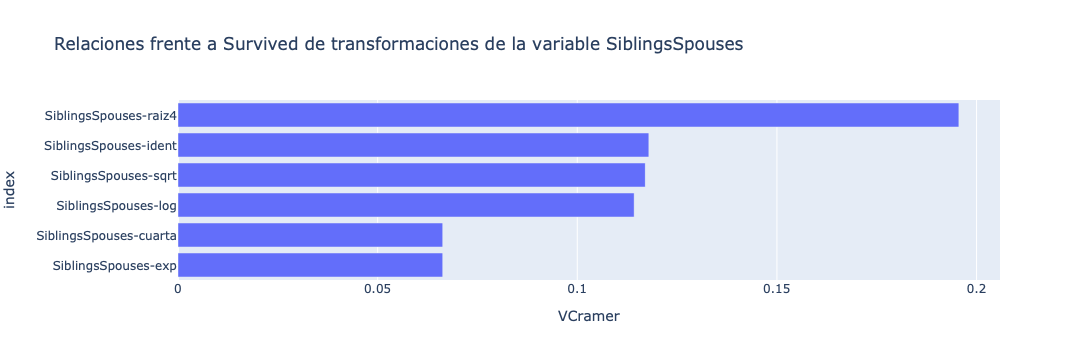

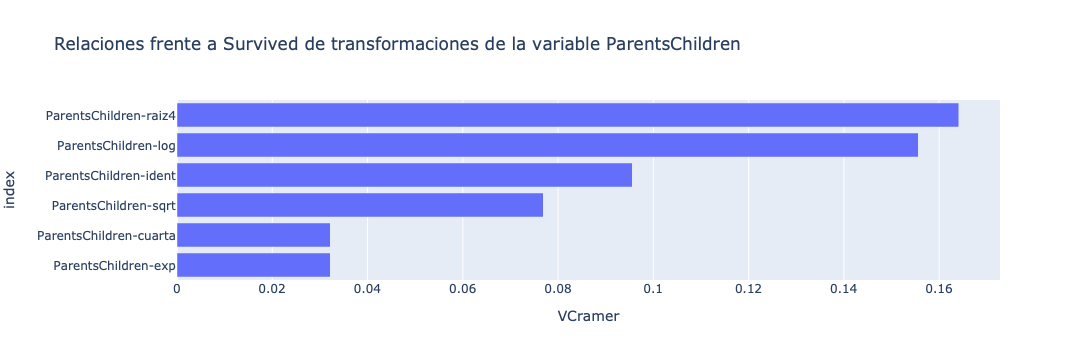

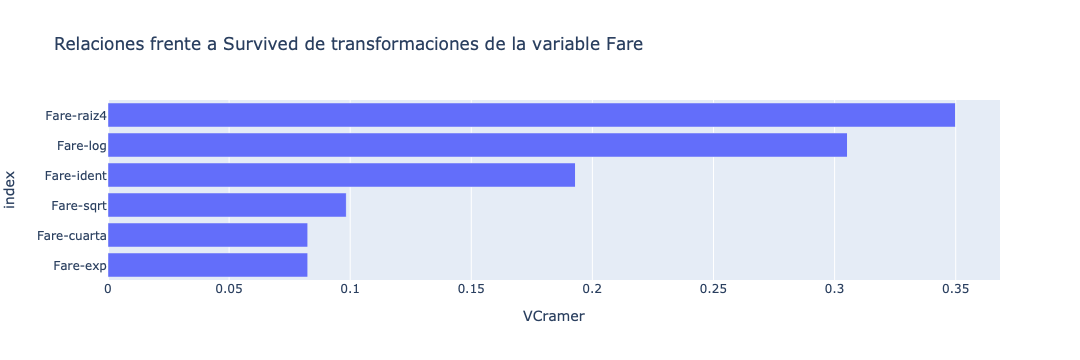

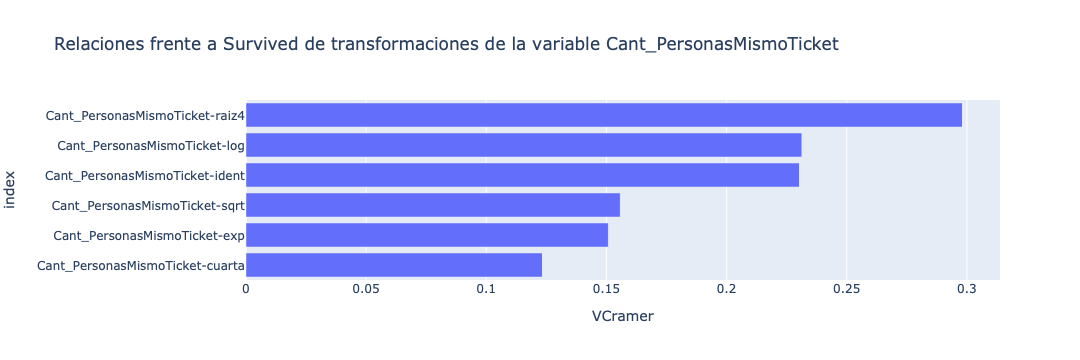

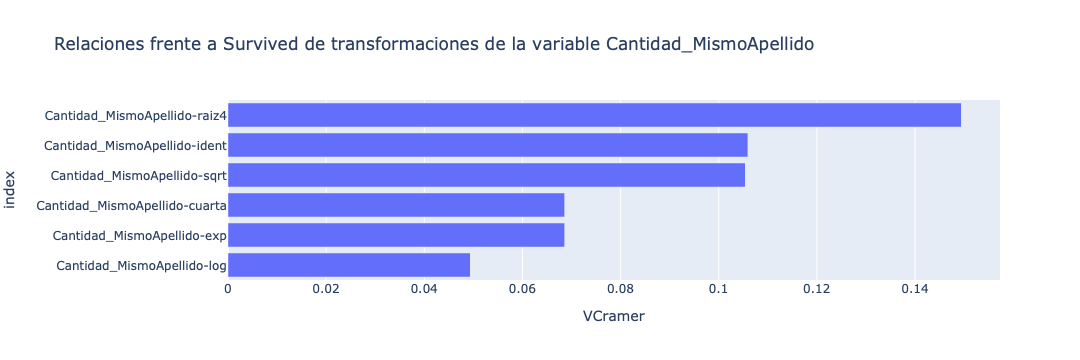

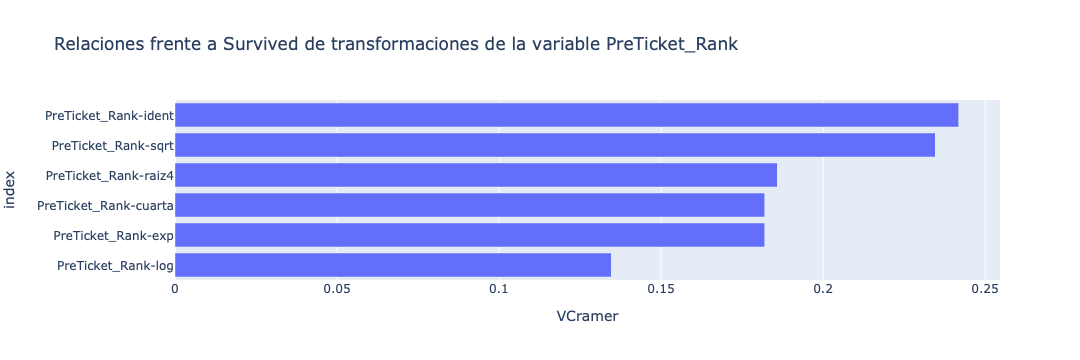

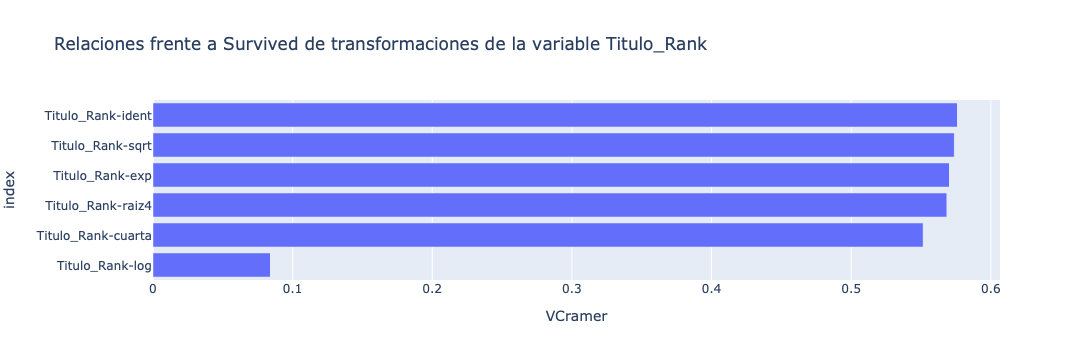

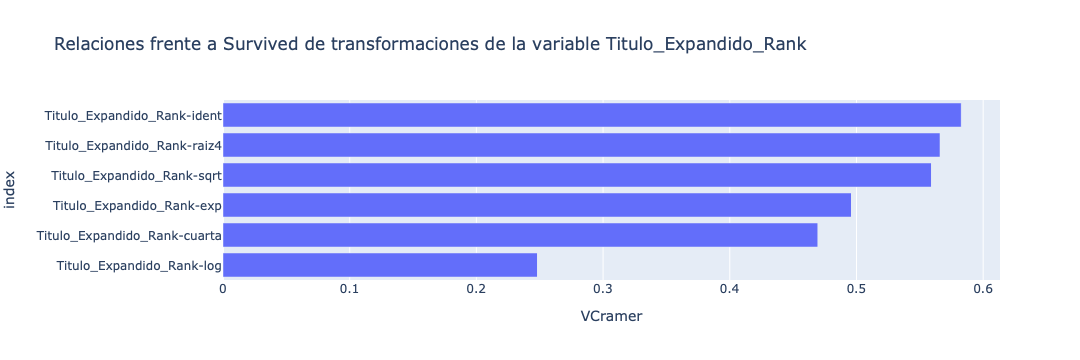

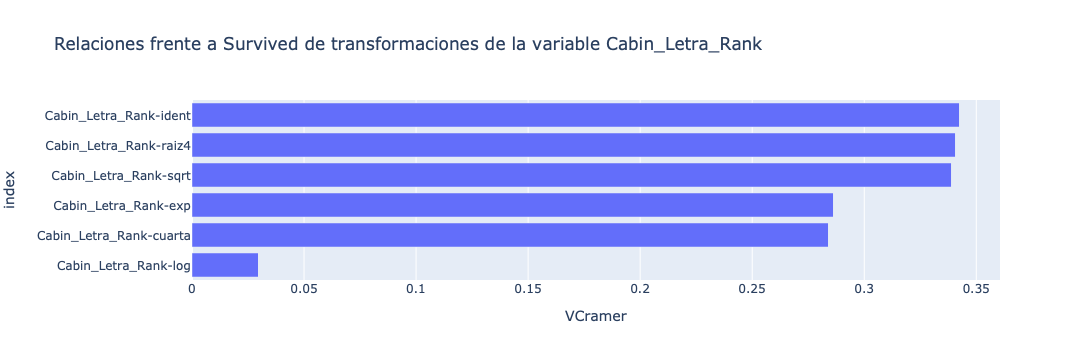

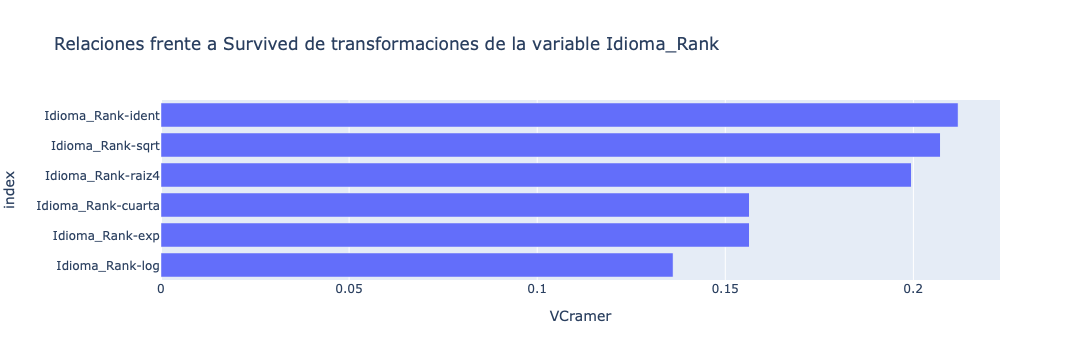

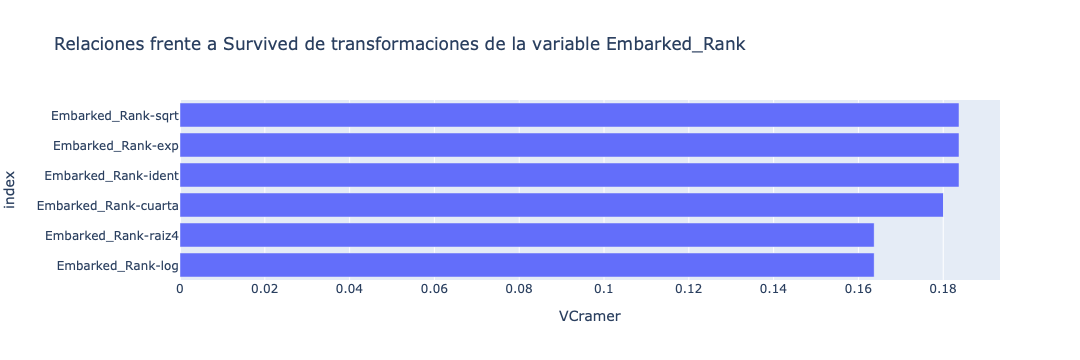

In [9]:
train_set.drop("PassengerId",axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,train_set.Survived, tipo='cramer', name = True, graf = True))

df_transformaciones_nombre = X_train.drop(["random","random2"],axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,Y_train, tipo='cramer', name = True,escalar = False, evita_ceros = True))
df_transformaciones_valores = X_train.drop(["random","random2"],axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,Y_train, tipo='cramer',escalar = False, evita_ceros = True))

df_transformaciones_valores.columns = df_transformaciones_nombre

X_train = pd.concat([X_train, df_transformaciones_valores], axis = 1).drop(["Titulo_Rank-ident"], axis = 1, inplace = False)

#Se le aplican las transformaciones a X_test
X_test = transf_test(X_test,df_transformaciones_nombre)



In [10]:
X_train.drop(["random","random2","Embarked_Rank-ident"],axis = 1,inplace = True)


<Axes: >

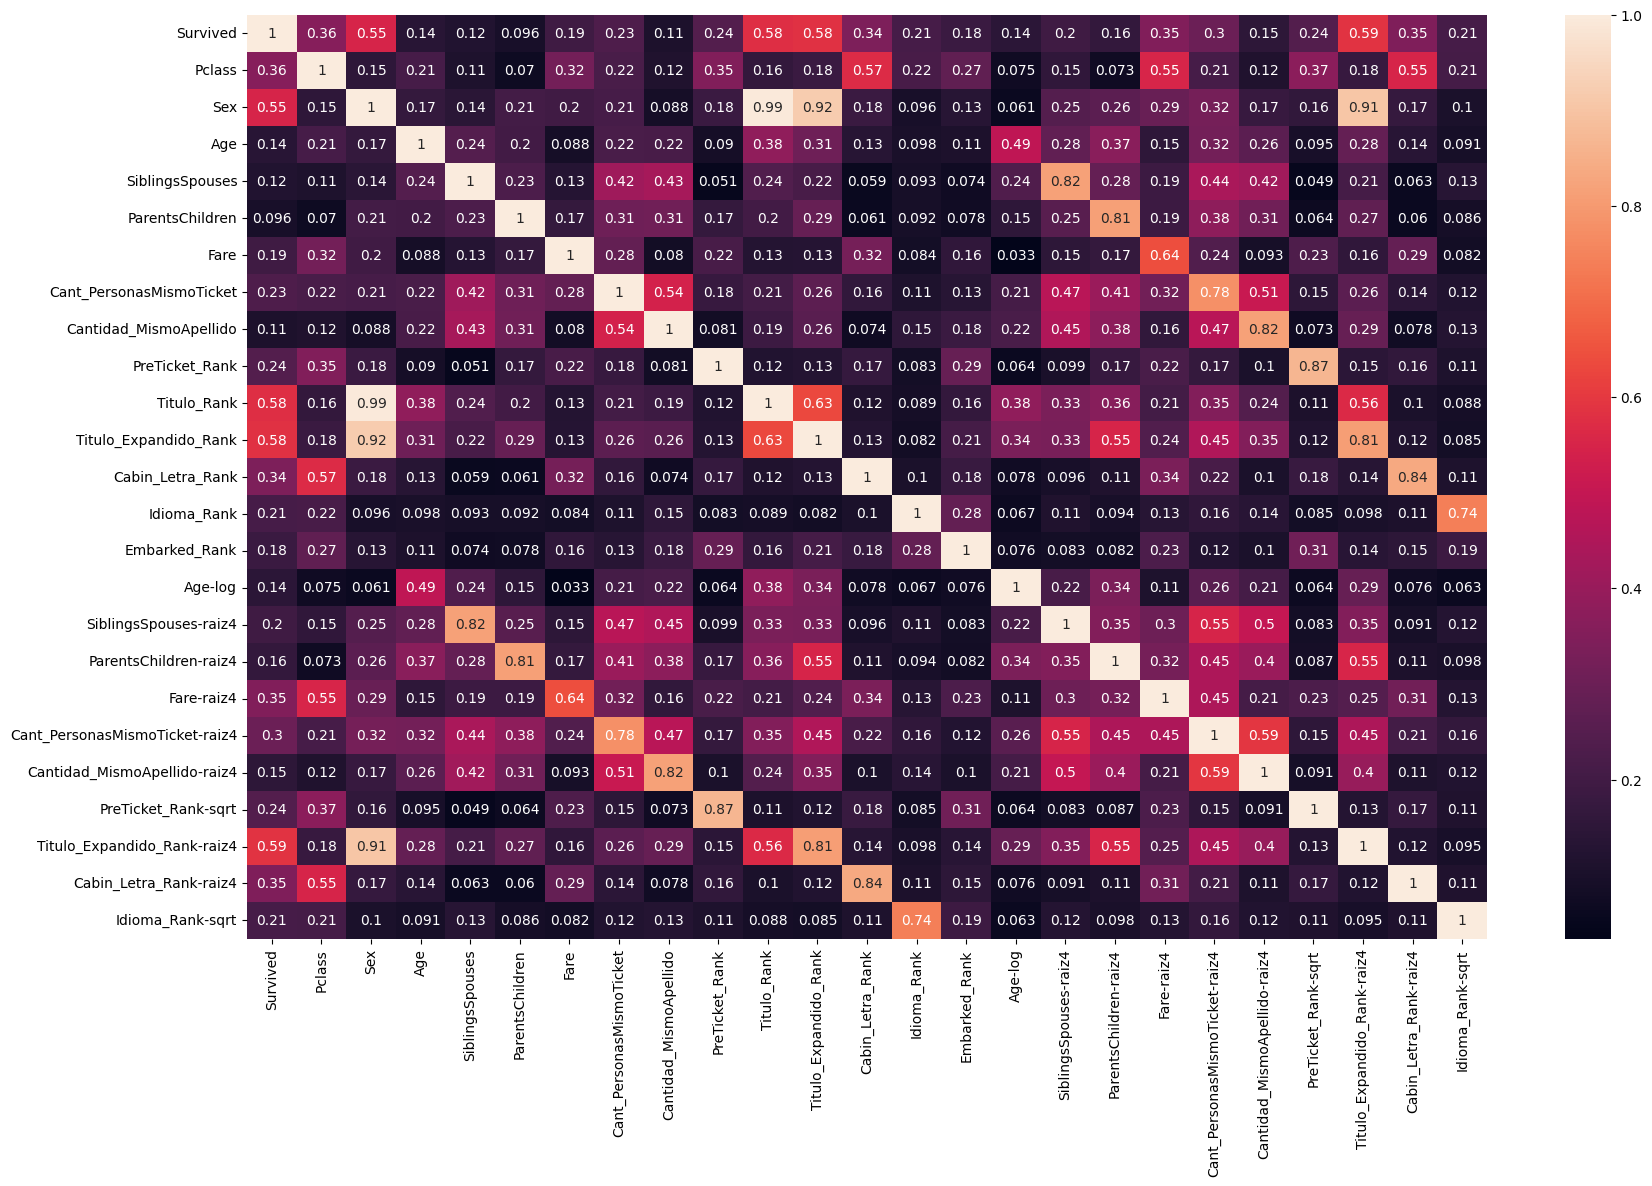

In [11]:
train_set = pd.concat([Y_train,X_train], axis = 1)

corr = NuestrasFunciones.get_cat_corr_mat(train_set)
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

## Modelado manual sin fine-tunning. Para darnos una idea de qué tanto mejora el poder predictivo una vez que usamos los selectores automáticos

In [12]:
X_train = sm.add_constant(X_train)
#X_train.dtypes
log_reg_sm = sm.Logit(Y_train, X_train).fit() 
print(log_reg_sm.summary())
X_train.drop("const", axis = 1, inplace = True)

Optimization terminated successfully.
         Current function value: 0.379367
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      687
Method:                           MLE   Df Model:                           24
Date:                Fri, 26 Jan 2024   Pseudo R-squ.:                  0.4301
Time:                        09:42:18   Log-Likelihood:                -270.11
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 1.912e-71
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -8.1597      6.934     -1.177     

Modelo: Survived ~ Pclass + Sex + Age + SiblingsSpouses + ParentsChildren + Fare + Cant_PersonasMismoTicket + Cantidad_MismoApellido + PreTicket_Rank + Titulo_Rank + Titulo_Expandido_Rank + Cabin_Letra_Rank + Idioma_Rank + Embarked_Rank + Age-log + SiblingsSpouses-raiz4 + ParentsChildren-raiz4 + Fare-raiz4 + Cant_PersonasMismoTicket-raiz4 + Cantidad_MismoApellido-raiz4 + PreTicket_Rank-sqrt + Titulo_Expandido_Rank-raiz4 + Cabin_Letra_Rank-raiz4 + Idioma_Rank-sqrt
AUC: 0.878 (0.028)
Accuracy: 0.832 (0.029)
F1: 0.866 (0.025)


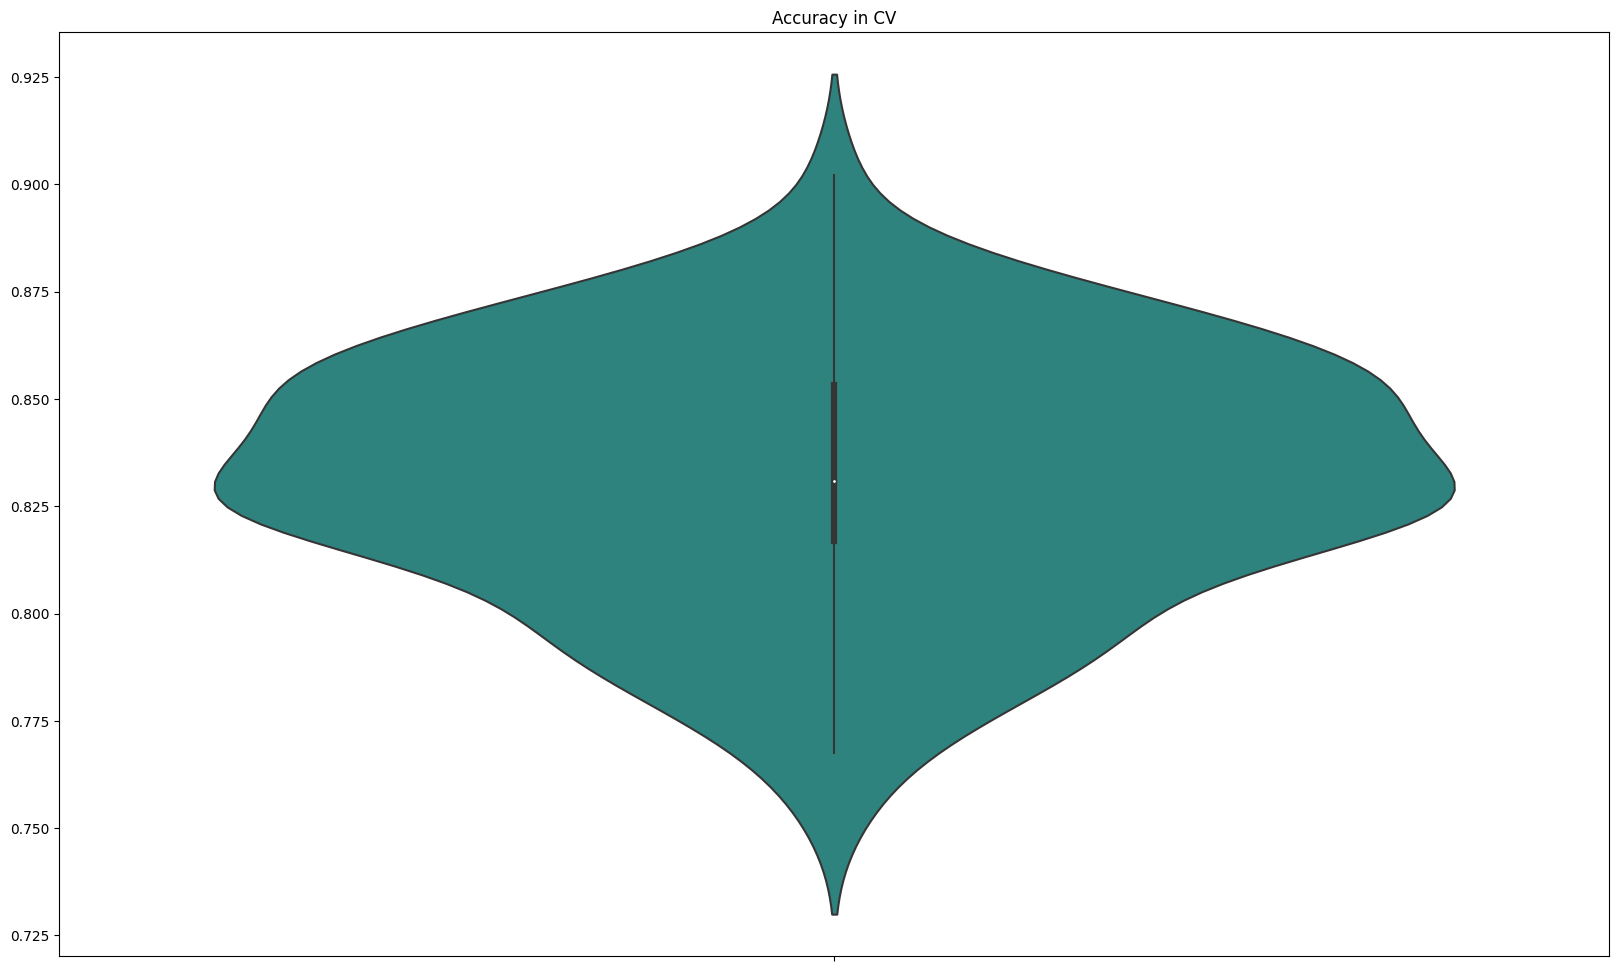

In [13]:
formula_transf0 = NuestrasFunciones.ols_formula(train_set,"Survived")
NuestrasFunciones.cross_val_log(formula_transf0,train_set)

Resultados del Sequential Forwards Feature Selector:
Accuracy en training de: 0.8412921348314606

13 Features elegidas
Las columnas son: ('Sex', 'SiblingsSpouses', 'ParentsChildren', 'Cant_PersonasMismoTicket', 'Cantidad_MismoApellido', 'Titulo_Rank', 'Idioma_Rank', 'Age-log', 'SiblingsSpouses-raiz4', 'ParentsChildren-raiz4', 'PreTicket_Rank-sqrt', 'Cabin_Letra_Rank-raiz4', 'Idioma_Rank-sqrt')


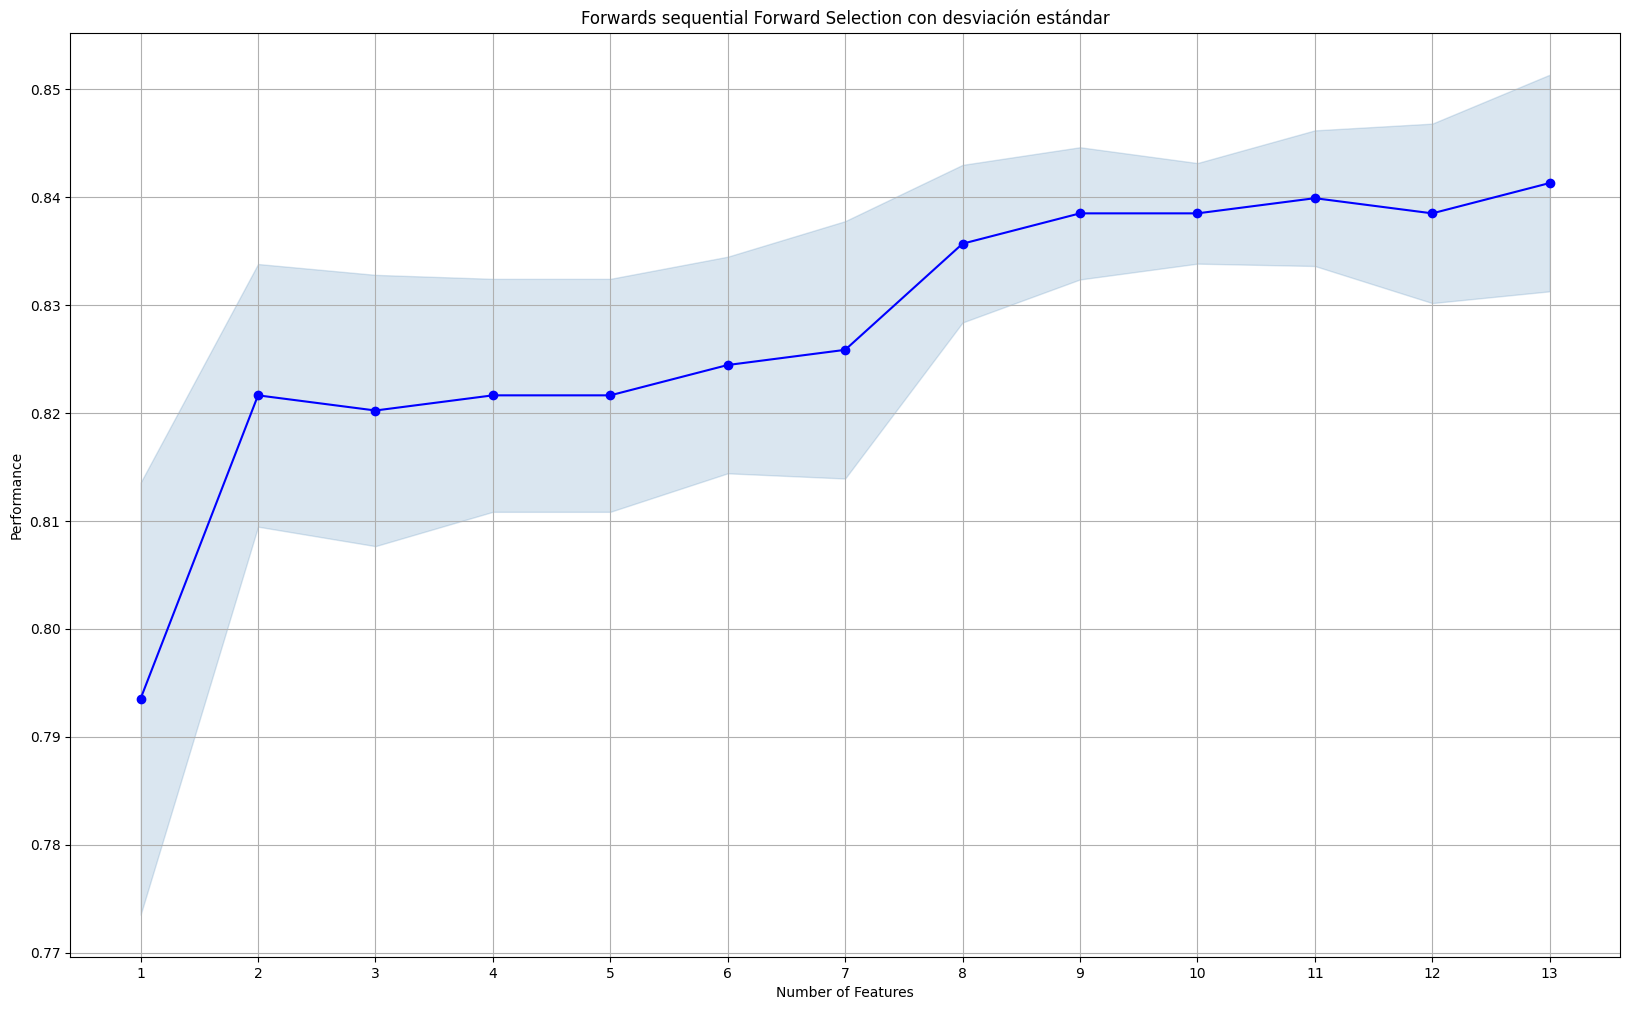

In [14]:
LogReg = LogisticRegression(max_iter = 100000000)

#K-features 13 se sacó de manera iterativa revisando los gráficos 
forwards_sfs = SFS(LogReg, 
           k_features= 13, 
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=4,
           n_jobs = -1)

forwards_sfs = forwards_sfs.fit(X_train, Y_train)
print("Resultados del Sequential Forwards Feature Selector:")
print(f"Accuracy en training de: {forwards_sfs.k_score_}")
print()
print(f"{len(forwards_sfs.k_feature_names_)} Features elegidas")
print(f"Las columnas son: {forwards_sfs.k_feature_names_}")

fig1 = plot_sfs(forwards_sfs.get_metric_dict(), kind='std_dev')
plt.title('Forwards sequential Forward Selection con desviación estándar')
plt.grid()

Modelo: Survived ~ Sex + SiblingsSpouses + ParentsChildren + Cant_PersonasMismoTicket + Cantidad_MismoApellido + Titulo_Rank + Cabin_Letra_Rank + Idioma_Rank + Age-log + SiblingsSpouses-raiz4 + ParentsChildren-raiz4 + Cant_PersonasMismoTicket-raiz4 + PreTicket_Rank-sqrt + Cabin_Letra_Rank-raiz4 + Idioma_Rank-sqrt
AUC: 0.877 (0.029)
Accuracy: 0.831 (0.032)
F1: 0.865 (0.027)


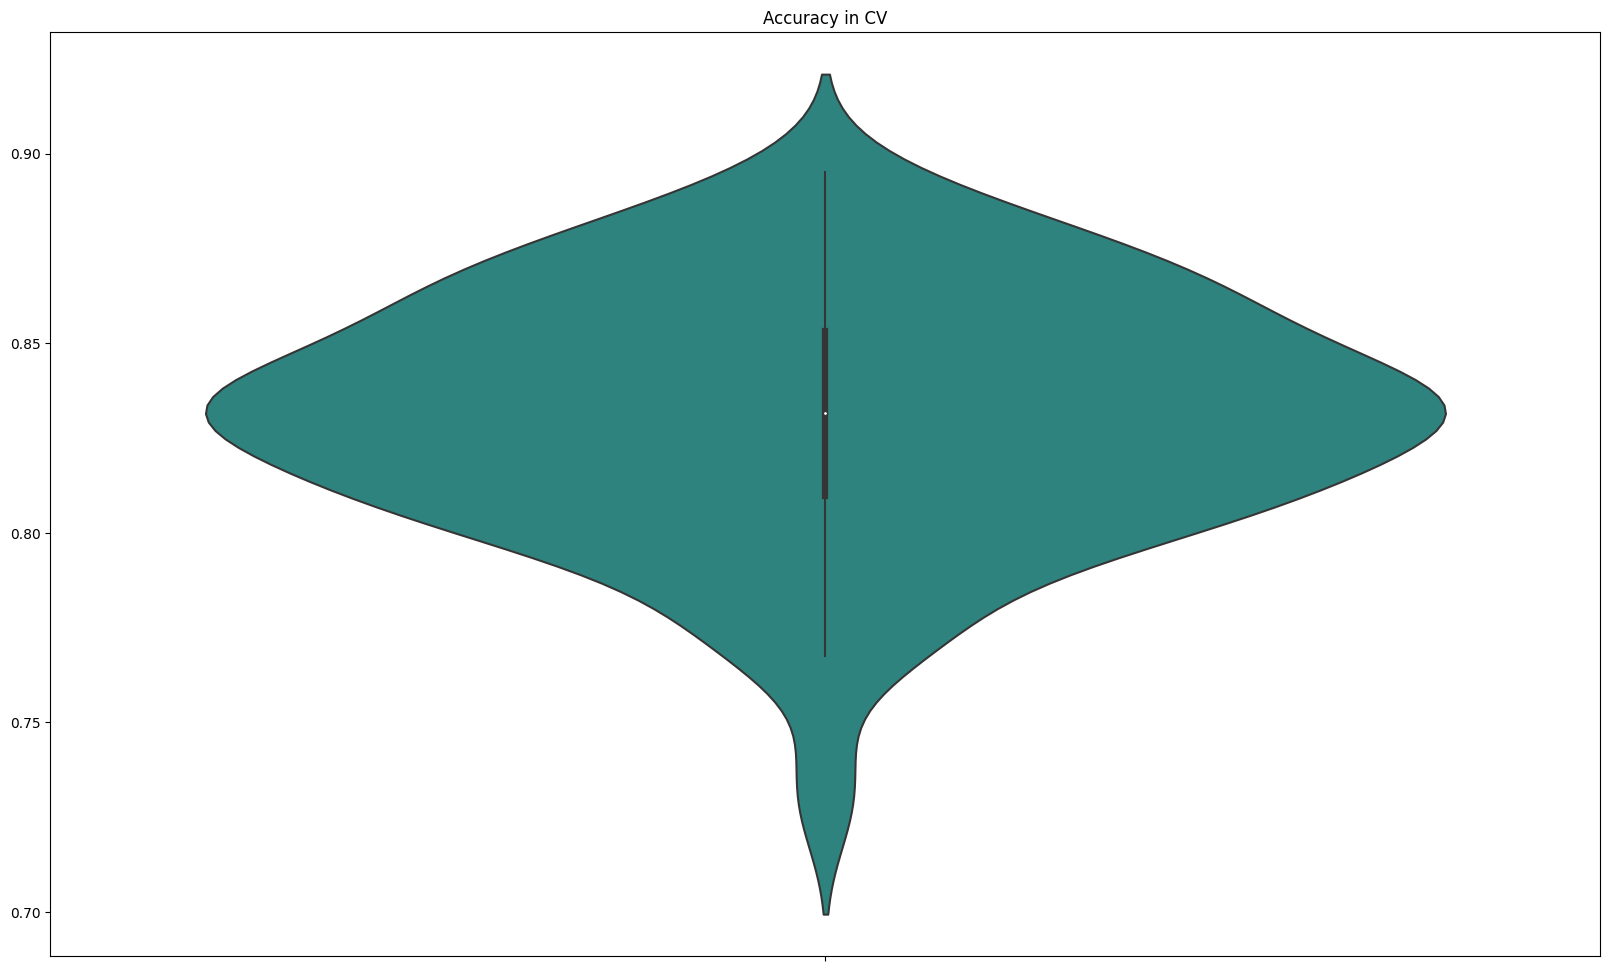

In [15]:
keep_forwards_sfs = list(forwards_sfs.k_feature_names_)

formula_transf_forwards_sfs = NuestrasFunciones.ols_formula_list(train_set,"Survived", keep_forwards_sfs, keep = True)

NuestrasFunciones.cross_val_log(formula_transf_forwards_sfs,train_set)


Resultados del Sequential Backwards Feature Selector:
Accuracy en training de: 0.8539325842696629

14 Features elegidas
Las columnas son: ('Pclass', 'Sex', 'Age', 'SiblingsSpouses', 'ParentsChildren', 'PreTicket_Rank', 'Titulo_Expandido_Rank', 'Cabin_Letra_Rank', 'Idioma_Rank', 'Age-log', 'SiblingsSpouses-raiz4', 'Cantidad_MismoApellido-raiz4', 'PreTicket_Rank-sqrt', 'Idioma_Rank-sqrt')


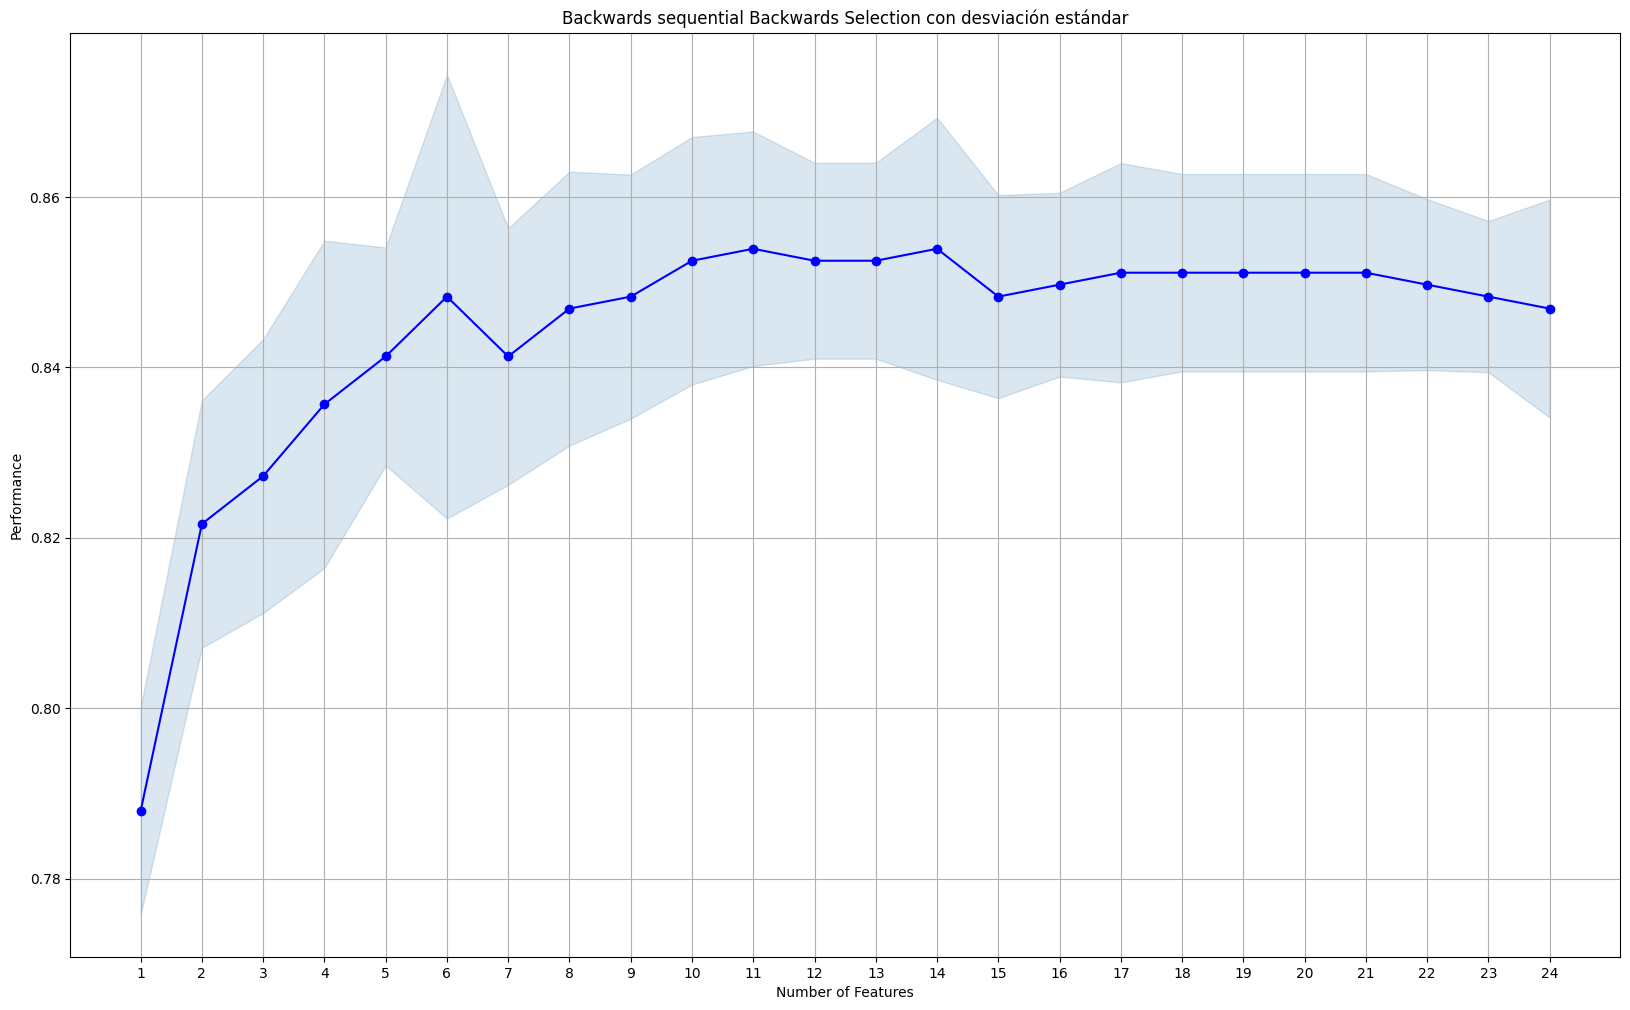

In [16]:
LogReg = LogisticRegression(max_iter = 10000000000)

back_sfs = SFS(LogReg, 
           k_features= "best", 
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=4,
           n_jobs = -1)

back_sfs = back_sfs.fit(X_train, Y_train)
print("Resultados del Sequential Backwards Feature Selector:")
print(f"Accuracy en training de: {back_sfs.k_score_}")
print()
print(f"{len(back_sfs.k_feature_names_)} Features elegidas")
print(f"Las columnas son: {back_sfs.k_feature_names_}")

fig2 = plot_sfs(back_sfs.get_metric_dict(), kind='std_dev')
plt.title('Backwards sequential Backwards Selection con desviación estándar')
plt.grid()

Modelo: Survived ~ Pclass + Sex + Age + SiblingsSpouses + ParentsChildren + Cant_PersonasMismoTicket + PreTicket_Rank + Titulo_Expandido_Rank + Cabin_Letra_Rank + Idioma_Rank + Age-log + SiblingsSpouses-raiz4 + Fare-raiz4 + Cantidad_MismoApellido-raiz4 + PreTicket_Rank-sqrt + Cabin_Letra_Rank-raiz4 + Idioma_Rank-sqrt
AUC: 0.877 (0.028)
Accuracy: 0.834 (0.030)
F1: 0.868 (0.025)


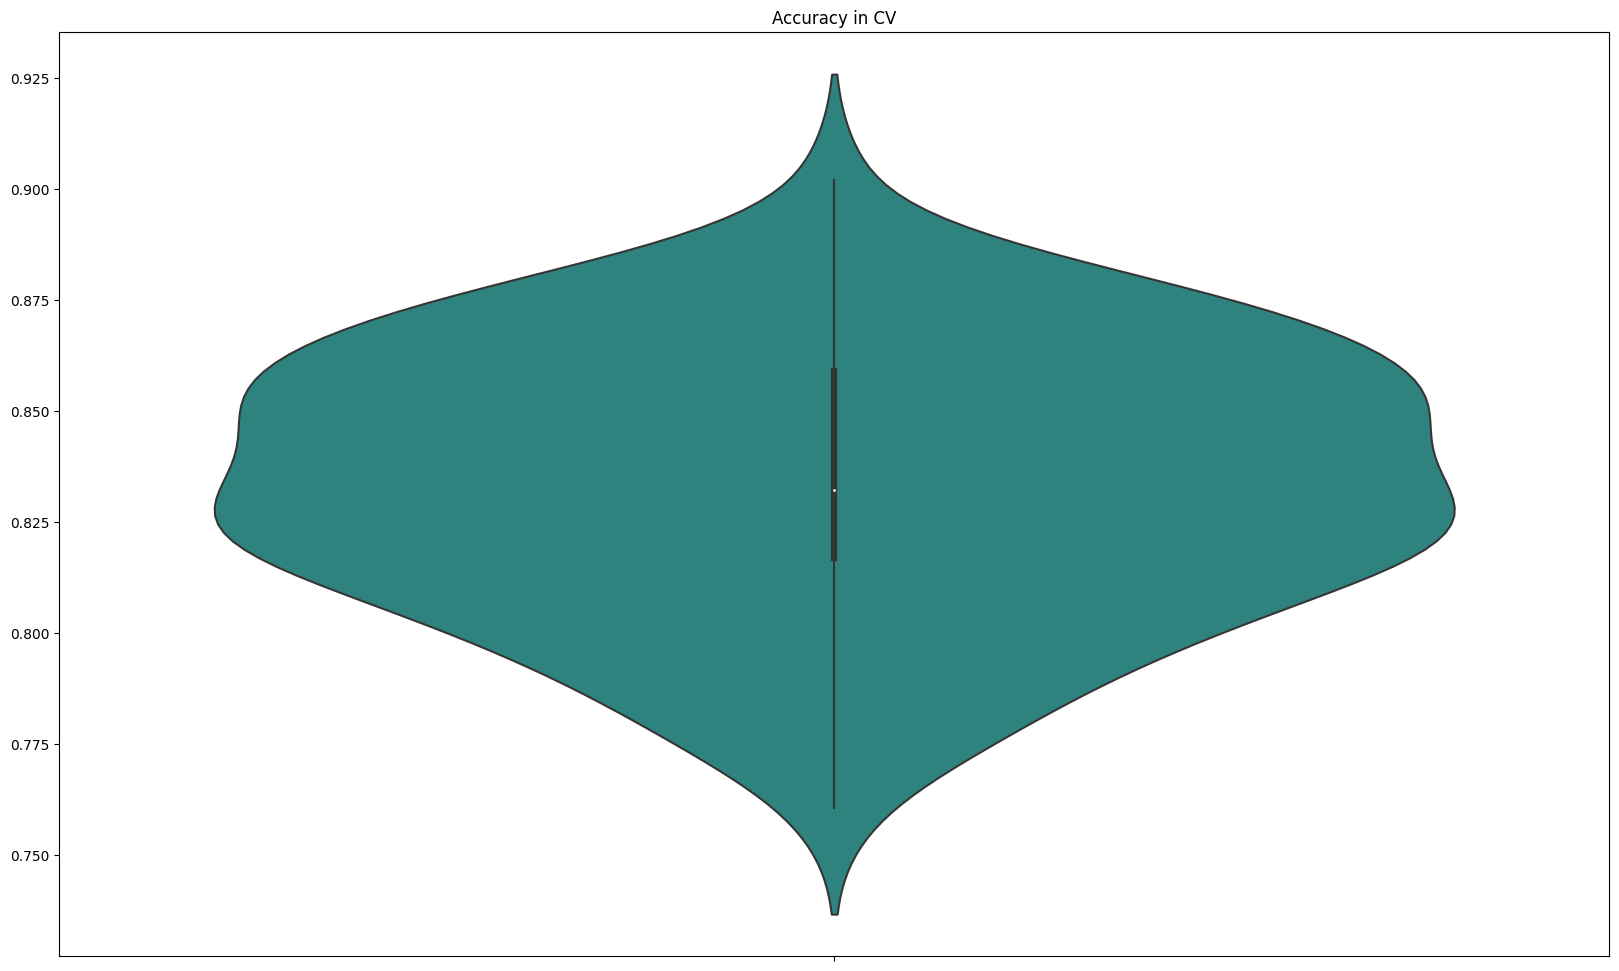

In [17]:
keep_backwards_sfs = list(back_sfs.k_feature_names_)

formula_transf_backwards_sfs = NuestrasFunciones.ols_formula_list(train_set,"Survived", keep_backwards_sfs, keep = True)

NuestrasFunciones.cross_val_log(formula_transf_backwards_sfs,train_set)


In [19]:
#Tarda demasiado tiempo, una lástima.
"""
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
LogReg = LogisticRegression(max_iter = 10000000000)

exhaustive_sfs = EFS(LogReg, 
           min_features=1,
           max_features=16,
           scoring='accuracy',
           print_progress=True,
           cv=4,
           n_jobs = -1)

exhaustive_sfs = exhaustive_sfs.fit(X_train, Y_train)
print("Resultados del Exhaustive Feature Selector:")
print(f"Accuracy en training de: {exhaustive_sfs.k_score_}")
print()
print(f"{len(exhaustive_sfs.k_feature_names_)} Features elegidas")
print(f"Las columnas son: {exhaustive_sfs.k_feature_names_}")

fig2 = plot_sfs(exhaustive_sfs.get_metric_dict(), kind='std_dev')
plt.title('Exhaustive Feature Selection con desviacón estándar')
plt.grid()
"""

'\nfrom mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS\nLogReg = LogisticRegression(max_iter = 10000000000)\n\nexhaustive_sfs = EFS(LogReg, \n           min_features=1,\n           max_features=16,\n           scoring=\'accuracy\',\n           print_progress=True,\n           cv=4,\n           n_jobs = -1)\n\nexhaustive_sfs = exhaustive_sfs.fit(X_train, Y_train)\nprint("Resultados del Exhaustive Feature Selector:")\nprint(f"Accuracy en training de: {exhaustive_sfs.k_score_}")\nprint()\nprint(f"{len(exhaustive_sfs.k_feature_names_)} Features elegidas")\nprint(f"Las columnas son: {exhaustive_sfs.k_feature_names_}")\n\nfig2 = plot_sfs(exhaustive_sfs.get_metric_dict(), kind=\'std_dev\')\nplt.title(\'Exhaustive Feature Selection con desviacón estándar\')\nplt.grid()\n'

#### Intentamos ahora PCA en vez de sfs

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

LogReg = LogisticRegression(max_iter = 10000000000, solver = "lbfgs")
pca = PCA()

parameters = {
    "pca__n_components": [0.6, 0.8],
    'logreg__penalty' : [None,'l2'], 
    'logreg__C'       : [0.001, 0.01, 0.1, 1, 10, 100],
}

pipe_model_transf_pca = Pipeline(steps=[("pca", pca), ("logreg", LogReg)])

grid_search_transf_pca = GridSearchCV(pipe_model_transf_pca, 
                   param_grid = parameters,
                   scoring = 'accuracy', 
                   cv = 4)


grid_search_transf_pca.fit(X_train,Y_train)
print("Tuned Hyperparameters :", grid_search_transf_pca.best_params_)
print("CV accuracy in grid search:",grid_search_transf_pca.best_score_)

Tuned Hyperparameters : {'logreg__C': 0.001, 'logreg__penalty': None, 'pca__n_components': 0.6}
CV accuracy in grid search: 0.6165730337078652


AUC: 0.649 (0.051)
Accuracy: 0.619 (0.030)
F1: 0.094 (0.064)


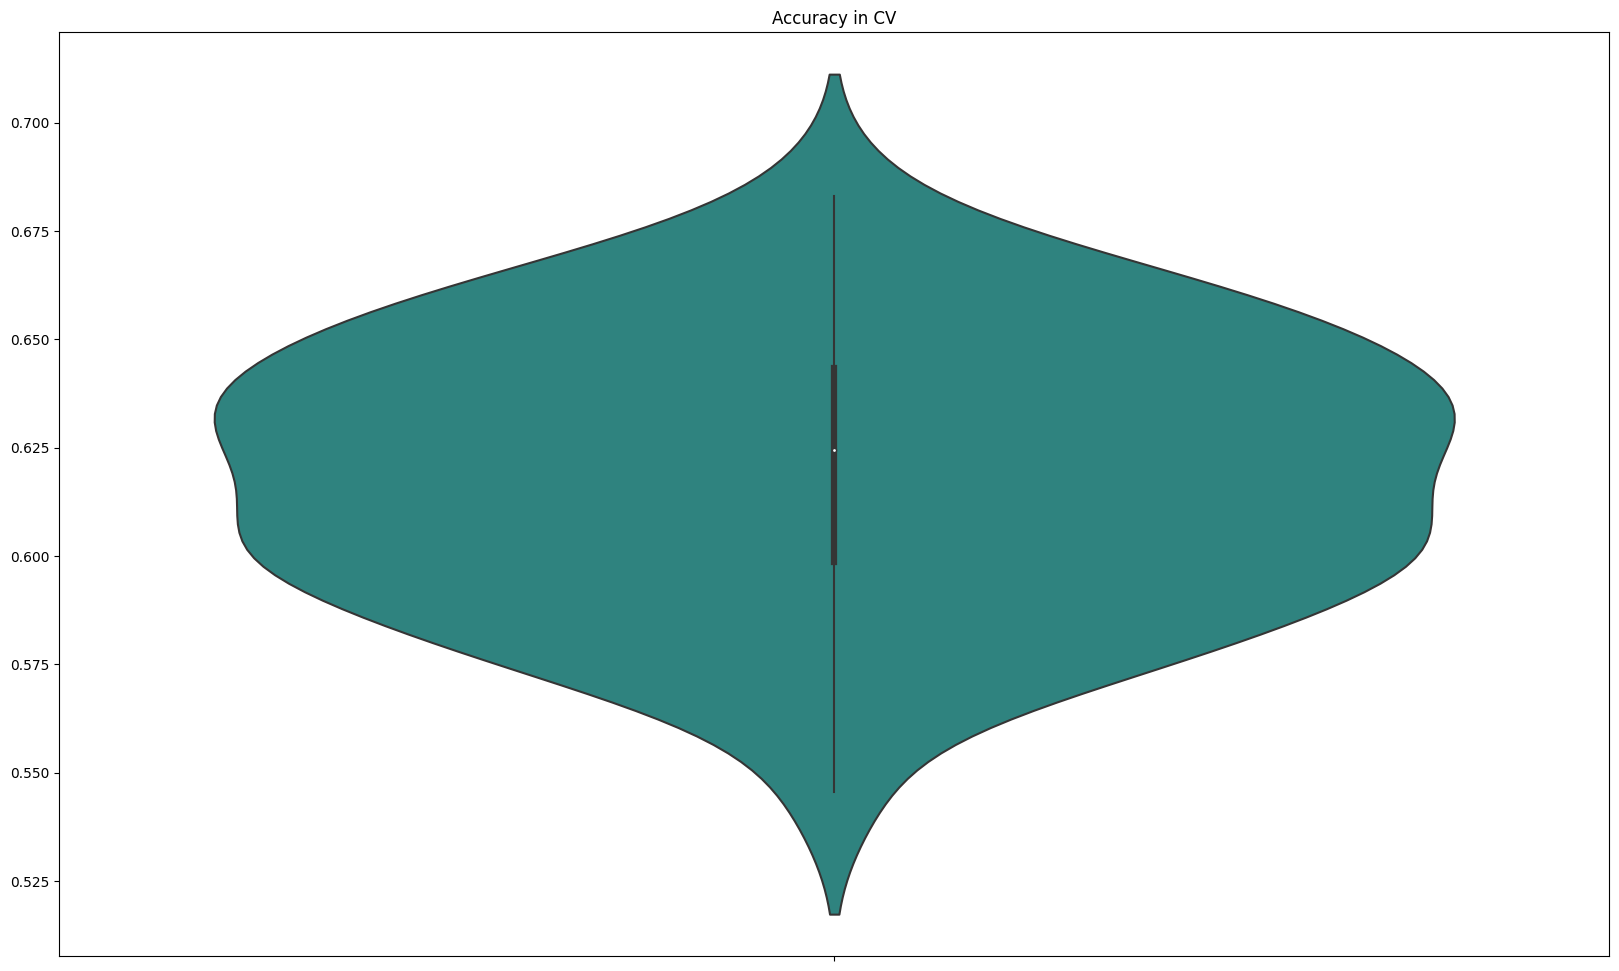

In [19]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

def cross_val_model(model, X, y, seed=123):

    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=seed)      

    scores_AUC = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    scores_Accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    scores_F1 = cross_val_score(model, X, y, scoring='f1', cv=cv)
  
    # Sesgo y varianza
    print('AUC: %.3f (%.3f)' % (np.mean(scores_AUC), np.std(scores_AUC)))
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores_Accuracy), np.std(scores_Accuracy)))
    print('F1: %.3f (%.3f)' % (np.mean(scores_F1), np.std(scores_F1)))
      
    sns.violinplot(y=scores_Accuracy,palette='viridis').set_title('Accuracy in CV')
      
    #return(scores)

cross_val_model(grid_search_transf_pca,X_train,Y_train)

#### El pca da unos resultados malísimos

In [20]:
lista_xtrain = list(X_train.columns)


In [21]:
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)


X_train_interac = X_train.copy()
X_train_interac = pd.DataFrame(interaction.fit_transform(X_train_interac), columns=interaction.get_feature_names_out(input_features=X_train_interac.columns))
X_train_interac = X_train_interac.loc[:, X_train_interac.var() != 0.0]
X_train_interac = X_train_interac.drop(lista_xtrain,axis = 1,inplace = False)

#Se le aplica a X_test
X_test_interac = X_test.copy()
X_test_interac = pd.DataFrame(interaction.fit_transform(X_test_interac), columns=interaction.get_feature_names_out(input_features=X_test_interac.columns))
X_test_interac = X_test_interac.loc[:, X_test_interac.var() != 0.0]
X_test_interac = X_test_interac.drop(lista_xtrain,axis = 1,inplace = False)



In [22]:
tablaCramer = pd.DataFrame(X_train_interac.apply(lambda x: NuestrasFunciones.cramers_v(x,Y_train)),columns=['VCramer'])
tablaCramer.sort_values(by = 'VCramer', ascending = False,inplace = True)
#tablaCramer.head(40)

inter_ToKeep = tablaCramer.loc[tablaCramer["VCramer"] > 0.40].index
print(f"interactions kept: {len(inter_ToKeep)}")

X_train_interac = X_train_interac[inter_ToKeep] 

#Se le aplica a X_test_interac
X_test_interac = X_test_interac[inter_ToKeep] 

interactions kept: 40


In [23]:
X_train_full = pd.concat([X_train,X_train_interac],axis = 1)
X_test_full = pd.concat([X_test,X_test_interac],axis = 1)


In [24]:
X_train_full.columns

Index(['Pclass', 'Sex', 'Age', 'SiblingsSpouses', 'ParentsChildren', 'Fare',
       'Cant_PersonasMismoTicket', 'Cantidad_MismoApellido', 'PreTicket_Rank',
       'Titulo_Rank', 'Titulo_Expandido_Rank', 'Cabin_Letra_Rank',
       'Idioma_Rank', 'Embarked_Rank', 'Age-log', 'SiblingsSpouses-raiz4',
       'ParentsChildren-raiz4', 'Fare-raiz4', 'Cant_PersonasMismoTicket-raiz4',
       'Cantidad_MismoApellido-raiz4', 'PreTicket_Rank-sqrt',
       'Titulo_Expandido_Rank-raiz4', 'Cabin_Letra_Rank-raiz4',
       'Idioma_Rank-sqrt', 'Titulo_Expandido_Rank Fare-raiz4',
       'Titulo_Expandido_Rank Cabin_Letra_Rank-raiz4',
       'Titulo_Rank Idioma_Rank',
       'Titulo_Expandido_Rank-raiz4 Cabin_Letra_Rank-raiz4',
       'Titulo_Expandido_Rank Idioma_Rank',
       'PreTicket_Rank Titulo_Expandido_Rank',
       'Titulo_Rank Cabin_Letra_Rank-raiz4', 'PreTicket_Rank Titulo_Rank',
       'Titulo_Rank Fare-raiz4', 'Titulo_Rank Titulo_Expandido_Rank',
       'Titulo_Rank Titulo_Expandido_Rank-raiz4

In [26]:
#NO LO LOGRA CON 40 INTERACCIONES
LogReg = LogisticRegression(max_iter = 1000000000)

forwards_sfs_full = SFS(LogReg, 
           k_features= "best", 
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=4,
           n_jobs = -1)

forwards_sfs_full = forwards_sfs_full.fit(X_train_full, Y_train)
print("Resultados del Sequential Forwards Feature Selector:")
print(f"Accuracy en training de: {forwards_sfs_full.k_score_}")
print()
print(f"{len(forwards_sfs_full.k_feature_names_)} Features elegidas")
print(f"Las columnas son: {forwards_sfs_full.k_feature_names_}")

fig1 = plot_sfs(forwards_sfs_full.get_metric_dict(), kind='std_dev')
plt.title('Forwards sequential Forward Selection con desviación estándar')
plt.grid()

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados del Sequential Forwards Feature Selector:
Accuracy en training de: None




STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: object of type 'NoneType' has no len()

Modelo: Survived ~ Pclass + Sex + Age + SiblingsSpouses + ParentsChildren + Fare + Cant_PersonasMismoTicket + Cantidad_MismoApellido + Titulo_Rank + Titulo_Expandido_Rank + Cabin_Letra_Rank + Embarked_Rank + SiblingsSpouses-raiz4 + ParentsChildren-raiz4 + Fare-raiz4 + Cant_PersonasMismoTicket-raiz4 + Cantidad_MismoApellido-raiz4 + Titulo_Expandido_Rank-raiz4 + Cabin_Letra_Rank-raiz4 + Idioma_Rank-sqrt
AUC: 0.877 (0.029)
Accuracy: 0.833 (0.028)
F1: 0.866 (0.023)


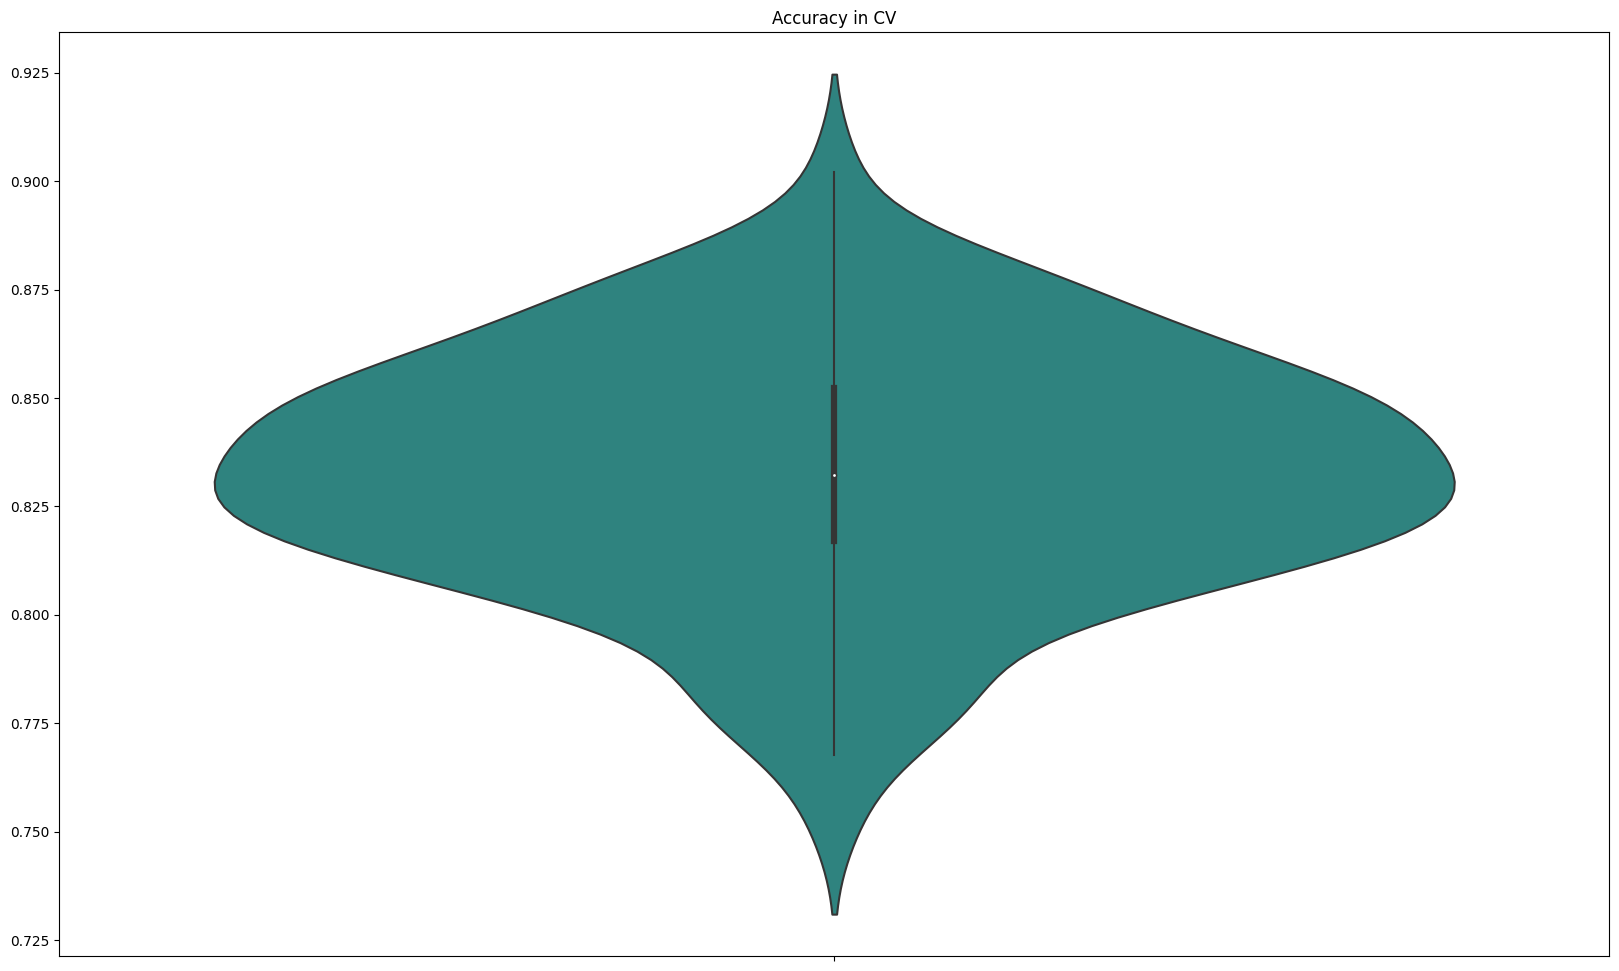

In [174]:
keep_AutoSelectorFull = list((forwards_sfs_full.k_feature_names_))

formula_full_forwards_sfs = NuestrasFunciones.ols_formula_list(train_set,"Survived", keep_AutoSelectorFull, keep = True)

NuestrasFunciones.cross_val_log(formula_full_forwards_sfs,train_set)


## Forward sequential feature selector elige ¡40! features y su accuracy es 0.02 sólo mayor que el forwards_sfs sin interacciones que elige 13 features

In [27]:
LogReg = LogisticRegression(max_iter = 10000000000, solver = "lbfgs")
pca = PCA()

parameters = {
    "pca__n_components": [0.6, 0.8],
    'logreg__penalty' : [None,'l2'], 
    'logreg__C'       : [0.001, 0.01, 0.1, 1, 10],
}

pipe_model_pca = Pipeline(steps=[("pca", pca), ("logreg", LogReg)])

grid_search_transf_inter_pca = GridSearchCV(pipe_model_pca, 
                   param_grid = parameters,
                   scoring = 'accuracy', 
                   cv = 4)


grid_search_transf_inter_pca.fit(X_train_full,Y_train)
print("Tuned Hyperparameters :", grid_search_transf_inter_pca.best_params_)
print("CV accuracy in grid search:",grid_search_transf_inter_pca.best_score_)

Tuned Hyperparameters : {'logreg__C': 0.001, 'logreg__penalty': None, 'pca__n_components': 0.6}
CV accuracy in grid search: 0.7823033707865168


AUC: 0.649 (0.051)
Accuracy: 0.619 (0.030)
F1: 0.094 (0.064)


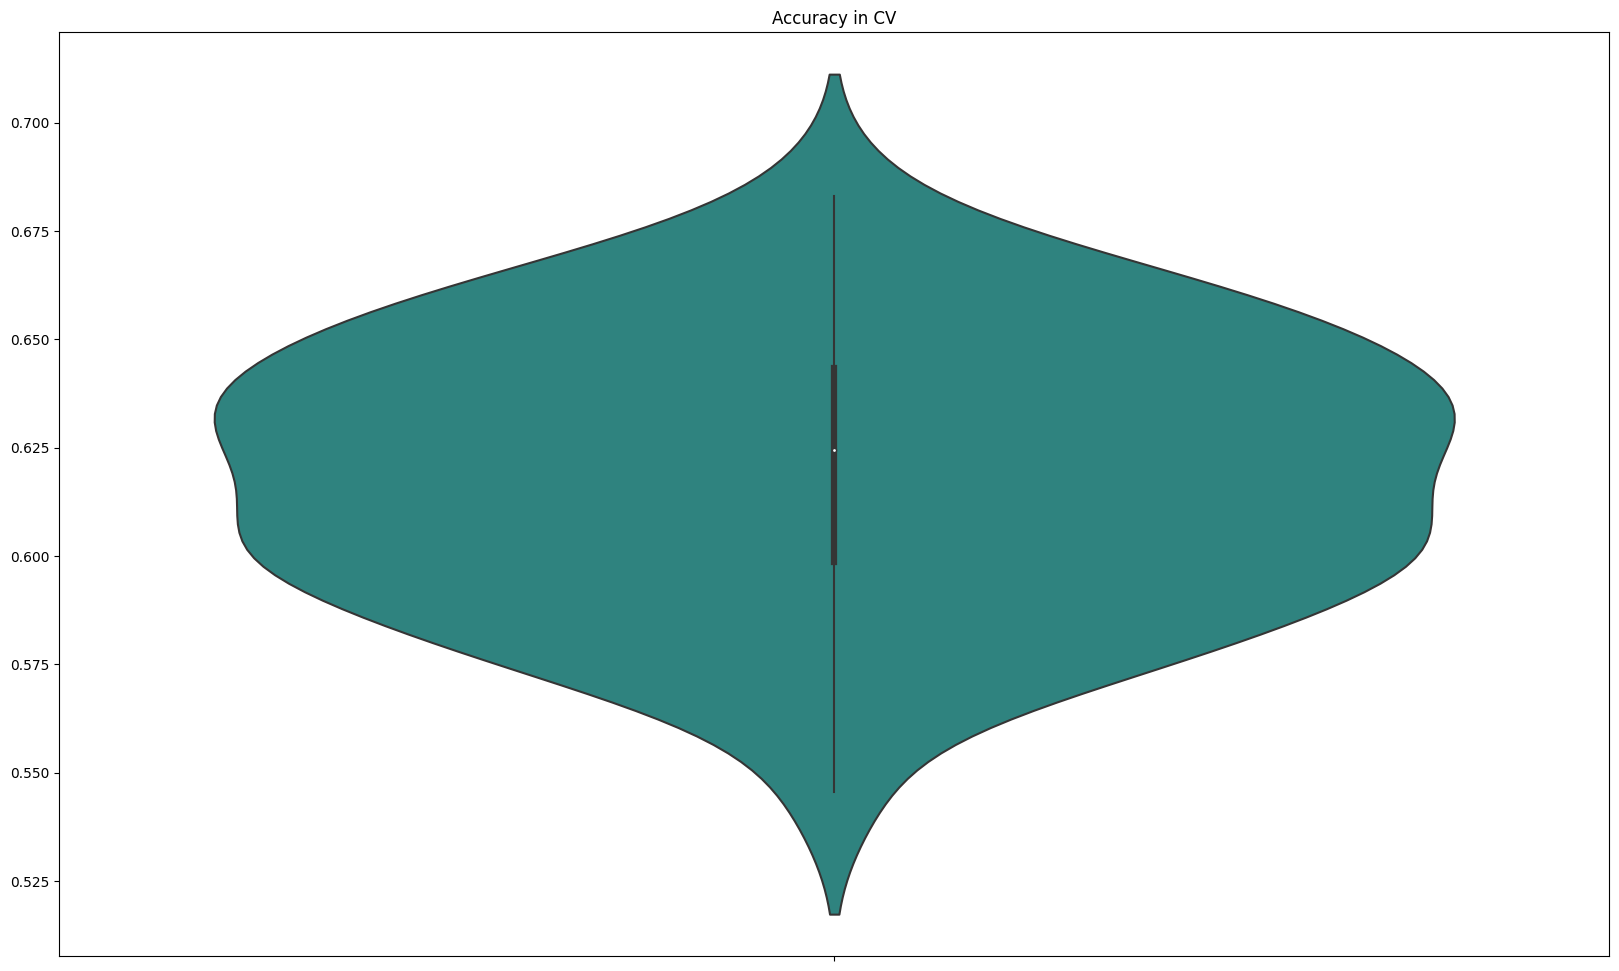

In [28]:
cross_val_model(grid_search_transf_inter_pca,X_train,Y_train)

### PCA tampoco es capaz de ayudar mucho aún con las interacciones

## Intentaré algo de selección manual de columnas

In [29]:
train_set = pd.concat([Y_train,X_train_full], axis = 1)
train_set.columns = [x.replace(" ","_") for x in train_set.columns]
train_set.columns = [x.replace("-","_") for x in train_set.columns]


#---------------------------
test_set = pd.concat([Y_test,X_test_full], axis = 1)
test_set.columns = [x.replace(" ","_") for x in test_set.columns]
test_set.columns = [x.replace("-","_") for x in test_set.columns]



Optimization terminated successfully.
         Current function value: 0.339119
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      647
Method:                           MLE   Df Model:                           64
Date:                Fri, 26 Jan 2024   Pseudo R-squ.:                  0.4906
Time:                        10:02:41   Log-Likelihood:                -241.45
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 3.297e-62
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                      

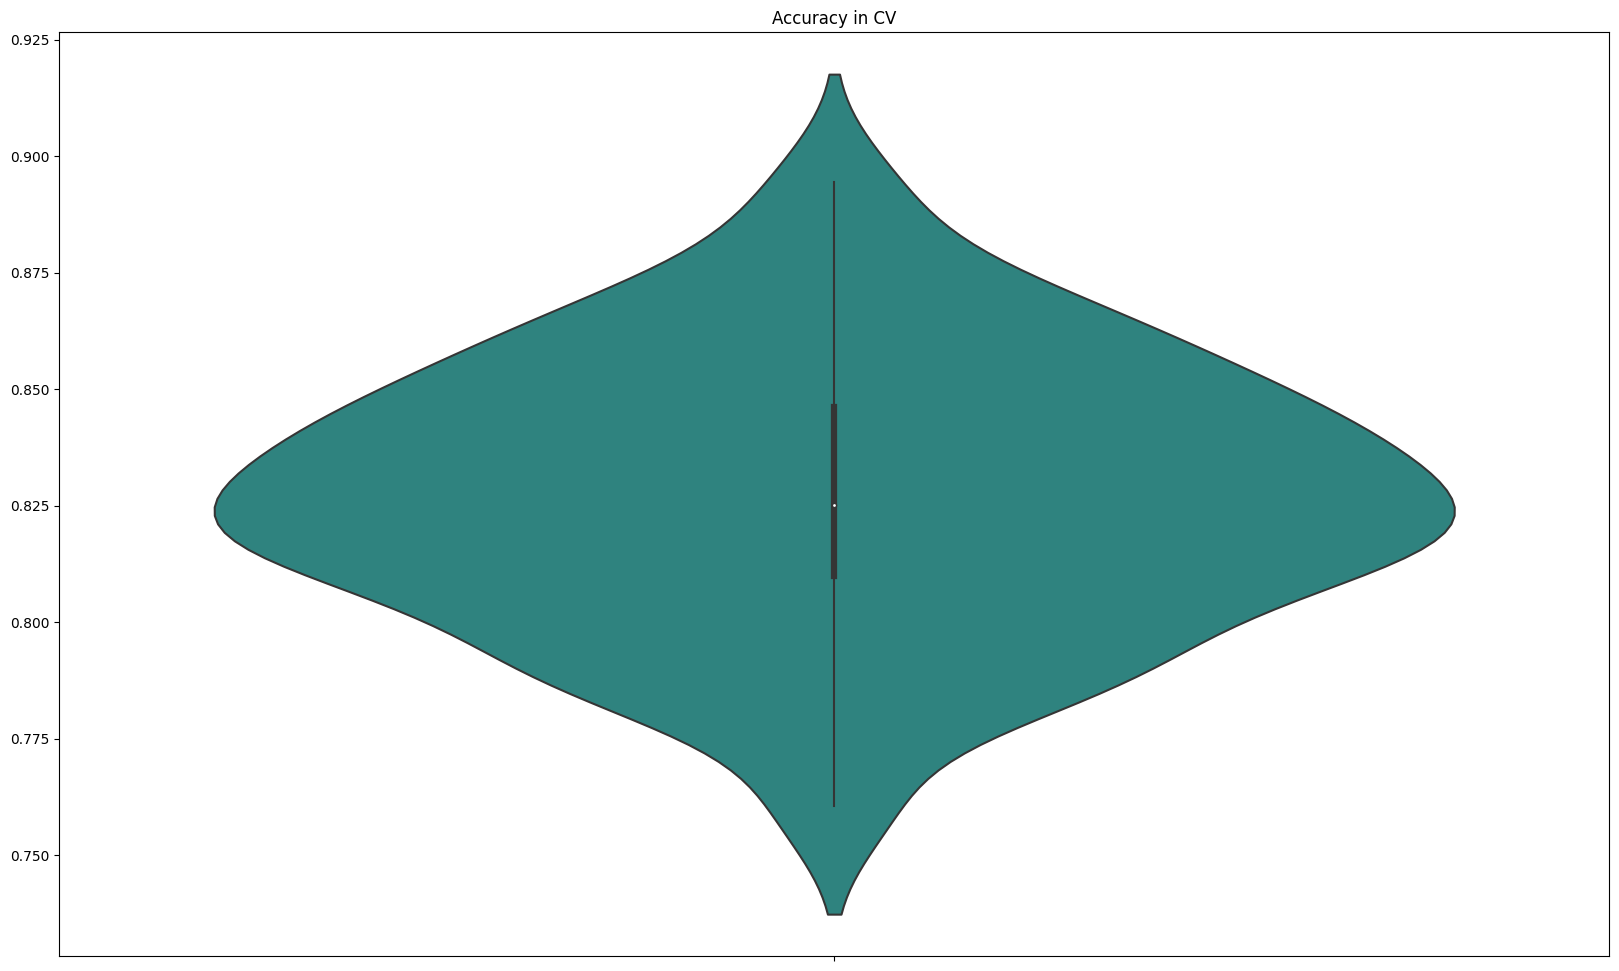

In [30]:
train_set_model0 = train_set.copy()
train_set_model0 = sm.add_constant(train_set_model0)

log_reg_sm0 = sm.Logit(Y_train, train_set_model0.drop("Survived",axis = 1)).fit() 
print(log_reg_sm0.summary())
train_set_model0.drop("const", axis = 1, inplace = True)

formula_transf_interac0 = NuestrasFunciones.ols_formula(train_set_model0,"Survived")
NuestrasFunciones.cross_val_log(formula_transf_interac0,train_set_model0)

In [49]:
#log_reg_sm0 = log_reg_sm0.summary()
#log_reg_sm0.tables[1].as_html()
#log_reg_sm0 = pd.read_html(results_as_html, header=0, index_col=0)[0]
#log_reg_sm0.sort_values(by = ["P>|z|"], ascending = False)[["P>|z|"]].head(5)


60

# Modelado manual estadísticamente significativo (menos SiblingsSopuses_raiz4) con el mejor poder predictivo hasta ahora!!

amount of features utilized: 11 

Optimization terminated successfully.
         Current function value: 0.376872
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                           10
Date:                Fri, 26 Jan 2024   Pseudo R-squ.:                  0.4339
Time:                        12:05:12   Log-Likelihood:                -268.33
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 3.671e-82
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const           

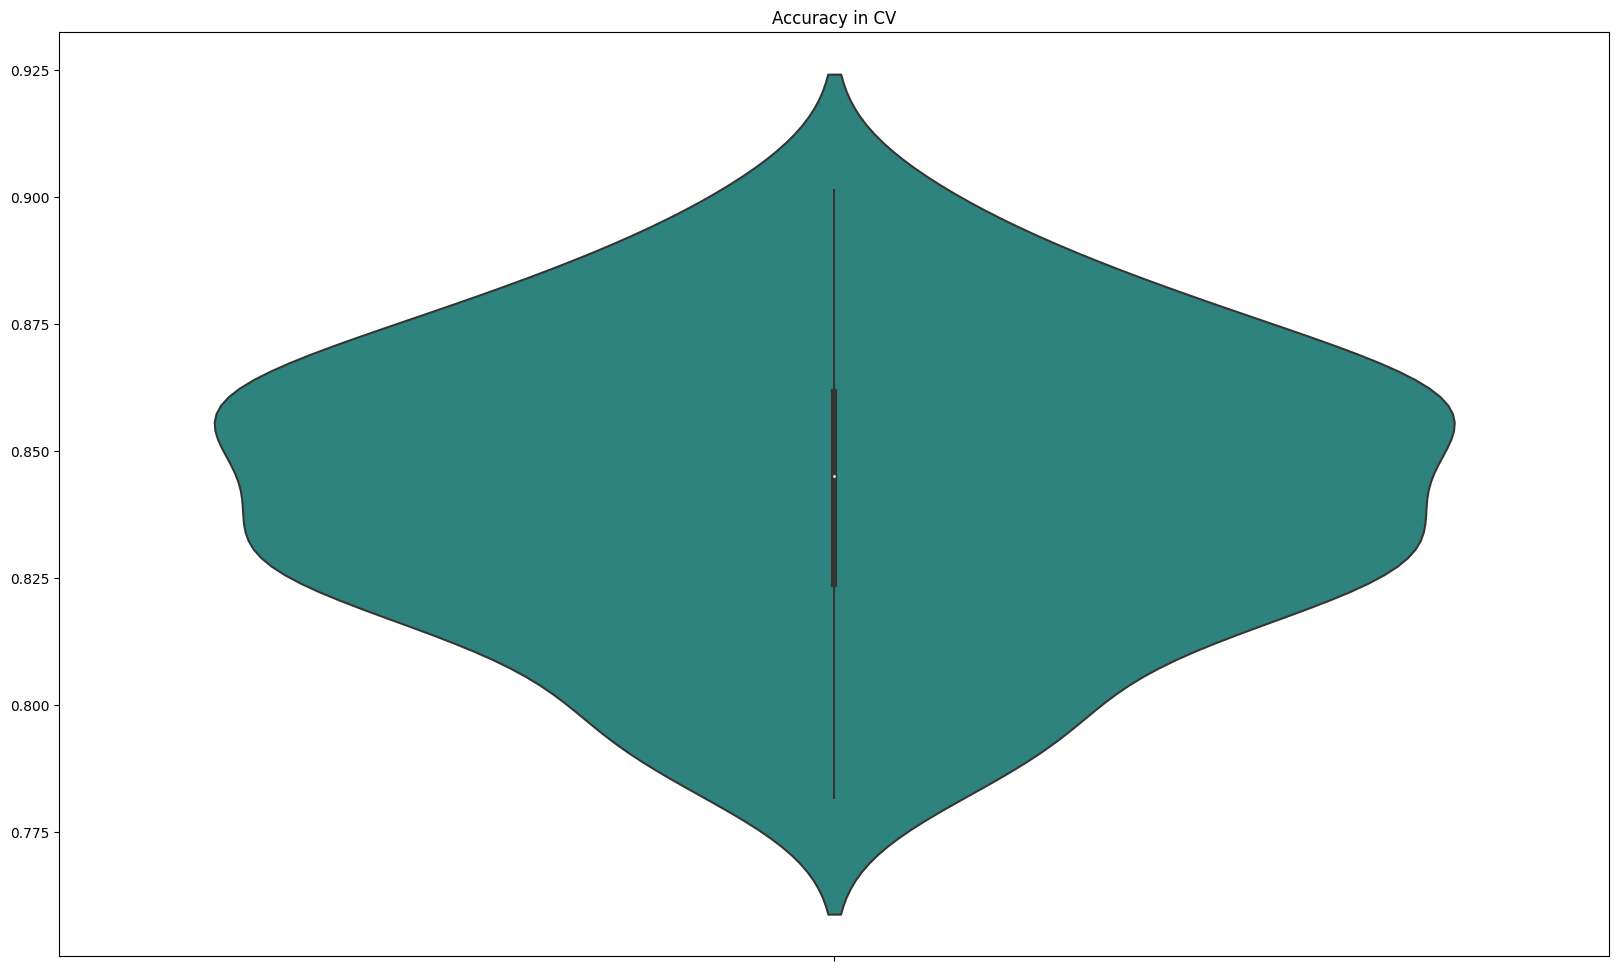

In [118]:
train_set_model1 = train_set.copy()
#train_set_model1.drop([""],axis = 1,inplace = True)

train_set_model1.drop(["Titulo_Rank_Titulo_Expandido_Rank","Titulo_Rank_Titulo_Expandido_Rank_raiz4","Titulo_Rank_Titulo_Expandido_Rank_raiz4","Titulo_Expandido_Rank_Titulo_Expandido_Rank_raiz4","Sex_PreTicket_Rank"],axis = 1,inplace = True)
train_set_model1.drop(["Sex_Idioma_Rank","Titulo_Expandido_Rank_Cabin_Letra_Rank","Sex_Age","Titulo_Rank_Idioma_Rank_sqrt","Titulo_Rank_PreTicket_Rank_sqrt"],axis = 1,inplace = True)
train_set_model1.drop(["Titulo_Expandido_Rank_raiz4","Fare","Sex_Titulo_Expandido_Rank_raiz4","Titulo_Expandido_Rank_PreTicket_Rank_sqrt","Titulo_Rank","Titulo_Rank_Cant_PersonasMismoTicket_raiz4"],axis = 1,inplace = True)
train_set_model1.drop(["PreTicket_Rank","Sex_PreTicket_Rank_sqrt","Fare_raiz4_Titulo_Expandido_Rank_raiz4","Cabin_Letra_Rank_raiz4","Titulo_Expandido_Rank_raiz4_Cabin_Letra_Rank_raiz4"],axis = 1,inplace = True)
train_set_model1.drop(["Pclass_Titulo_Expandido_Rank","PreTicket_Rank_Titulo_Expandido_Rank_raiz4","ParentsChildren","Cant_PersonasMismoTicket_raiz4","Sex_Idioma_Rank_sqrt","ParentsChildren_raiz4"],axis = 1,inplace = True)
train_set_model1.drop(["Titulo_Rank_Idioma_Rank","Sex_Cabin_Letra_Rank","Age","Titulo_Expandido_Rank_Cabin_Letra_Rank_raiz4","Titulo_Rank_Embarked_Rank","Cantidad_MismoApellido"],axis = 1,inplace = True)

train_set_model1.drop(["Cant_PersonasMismoTicket","Sex_Fare_raiz4","Age_Titulo_Rank","Titulo_Expandido_Rank_Fare_raiz4","Cantidad_MismoApellido_raiz4","Age_log","PreTicket_Rank_Titulo_Expandido_Rank"],axis = 1,inplace = True)


train_set_model1.drop(["Cabin_Letra_Rank","PreTicket_Rank_sqrt","Sex_Embarked_Rank","Titulo_Rank_Cabin_Letra_Rank_raiz4","Titulo_Rank_Cabin_Letra_Rank","Sex_Titulo_Rank","Embarked_Rank","Titulo_Expandido_Rank_Embarked_Rank"],axis = 1,inplace = True)
train_set_model1.drop(["Titulo_Expandido_Rank","Titulo_Rank_Fare_raiz4","Titulo_Expandido_Rank_Idioma_Rank","Fare_raiz4","Titulo_Expandido_Rank_Idioma_Rank_sqrt"],axis = 1,inplace = True)
train_set_model1.drop(["Idioma_Rank_sqrt","Titulo_Expandido_Rank_raiz4_Idioma_Rank_sqrt"],axis = 1,inplace = True)

#Por alguna razón al modelo entran tanto SiblingsSpouses como SiblingsSpouses_raiz4

print(f"amount of features utilized: {train_set_model1.shape[1]} \n")
#---------------------------------------------------
train_set_model1 = sm.add_constant(train_set_model1)

log_reg_sm1 = sm.Logit(Y_train, train_set_model1.drop("Survived",axis = 1)).fit() 
print(log_reg_sm1.summary())
train_set_model1.drop("const", axis = 1, inplace = True)
#---------------------------------------------------
log_reg_sm1_df = log_reg_sm1.summary()
log_reg_sm1_df = log_reg_sm1_df.tables[1].as_html()
log_reg_sm1_df = pd.read_html(log_reg_sm1_df, header=0, index_col=0)[0]
print(log_reg_sm1_df.sort_values(by = ["P>|z|"], ascending = False)[["P>|z|","std err"]].head(10))
#---------------------------------------------------
formula_transf_interac1 = NuestrasFunciones.ols_formula(train_set_model1,"Survived")
NuestrasFunciones.cross_val_log(formula_transf_interac1,train_set_model1,seed = np.random.randint(1000))

#PreTicket_Rank
#PreTicket_Rank_sqrt
#Titulo_Rank
#ParentsChildren_raiz4
#Cantidad_MismoApellido
#Cantidad_MismoApellido_raiz4
#Cant_PersonasMismoTicket

#Titulo_Rank_Titulo_Expandido_Rank, Titulo_Expandido_Rank
#Fare_raiz4
#SiblingsSpouses_raiz4




# Probaré en el test-set los dos mejores modelos

## Modelo manual

In [119]:
#train_set_model1.columns
#test1 = test_set.copy()

Y_test1 = test_set[["Survived"]].copy()

X_test1 = test_set[train_set_model1.columns].copy()


X_test1 = sm.add_constant(X_test1)
X_test1.drop("Survived", axis = 1, inplace = True)

continuous_pred = log_reg_sm1.predict(X_test1)

Scores in test:
Accuracy: 0.8268156424581006
Precision: 0.7714285714285715
Recall: 0.782608695652174
F1 Score: 0.7769784172661871

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



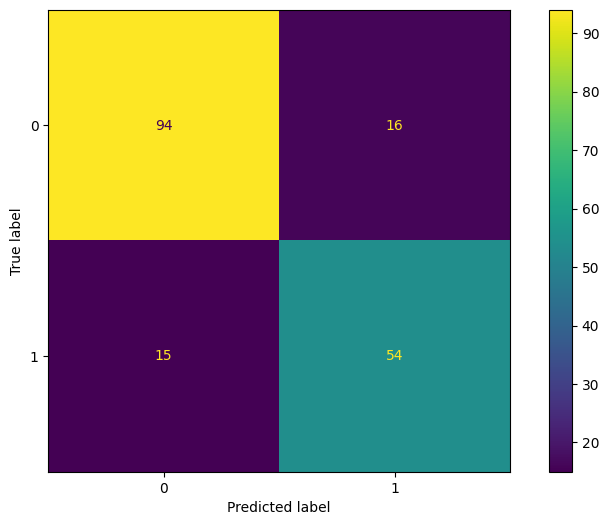

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

predictions = [round(x) for x in continuous_pred.values]
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()


#### Con ligero cambio en cut-off point:

Scores in test:
Accuracy: 0.8435754189944135
Precision: 0.8059701492537313
Recall: 0.782608695652174
F1 Score: 0.7941176470588236

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       110
           1       0.81      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



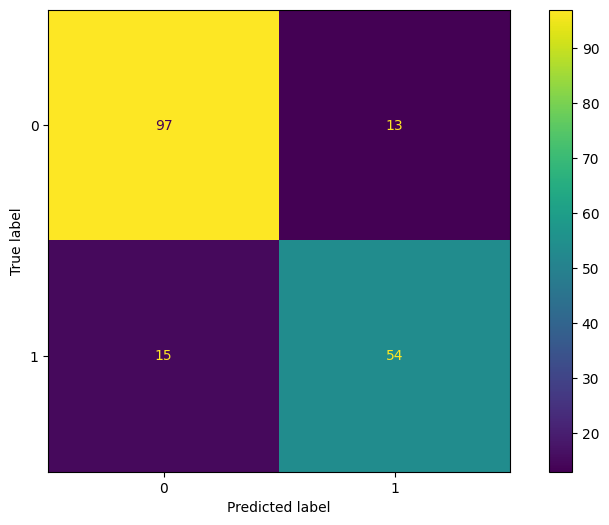

In [124]:
predictions = [0 if x < 0.65 else 1 for x in continuous_pred.values]

accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()


## Punto de corte en 0.65 me parece algo de overfitting a este test set, me quedo con el punto de corte en 0.5 

## Modelo del primer backwards feature selector, sin interacciones

In [127]:
X_test2 = test_set.copy()
train_set_model2 = train_set.drop("Survived",axis = 1).copy()

#Traemos las features elegidas por el forwards sfs
features_backwards_sfs_no_interac = ['Pclass', 'Sex', 'Age', 'SiblingsSpouses', 'ParentsChildren', 'PreTicket_Rank', 'Titulo_Expandido_Rank', 'Cabin_Letra_Rank', 'Idioma_Rank', 'Age-log', 'SiblingsSpouses-raiz4', 'Cantidad_MismoApellido-raiz4', 'PreTicket_Rank-sqrt', 'Idioma_Rank-sqrt']

features_backwards_sfs_no_interac = [x.replace("-","_") for x in features_backwards_sfs_no_interac]

train_set_model2 = train_set_model2[features_backwards_sfs_no_interac].copy()


train_set_model2 = sm.add_constant(train_set_model2)

log_reg_sm2 = sm.Logit(Y_train, train_set_model2).fit() 




Optimization terminated successfully.
         Current function value: 0.386600
         Iterations 7


In [129]:
X_test2 = X_test2[features_backwards_sfs_no_interac]
X_test2 = sm.add_constant(X_test2)

continuous_pred2 = log_reg_sm2.predict(X_test2)


Scores in test:
Accuracy: 0.8435754189944135
Precision: 0.8360655737704918
Recall: 0.7391304347826086
F1 Score: 0.7846153846153846

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



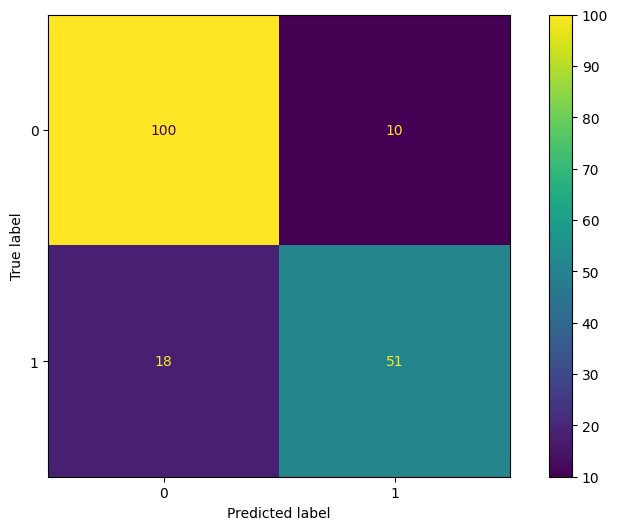

In [130]:
predictions = [round(x) for x in continuous_pred2.values]
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

Scores in test:
Accuracy: 0.8491620111731844
Precision: 0.8888888888888888
Recall: 0.6956521739130435
F1 Score: 0.7804878048780488

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       110
           1       0.89      0.70      0.78        69

    accuracy                           0.85       179
   macro avg       0.86      0.82      0.83       179
weighted avg       0.85      0.85      0.84       179



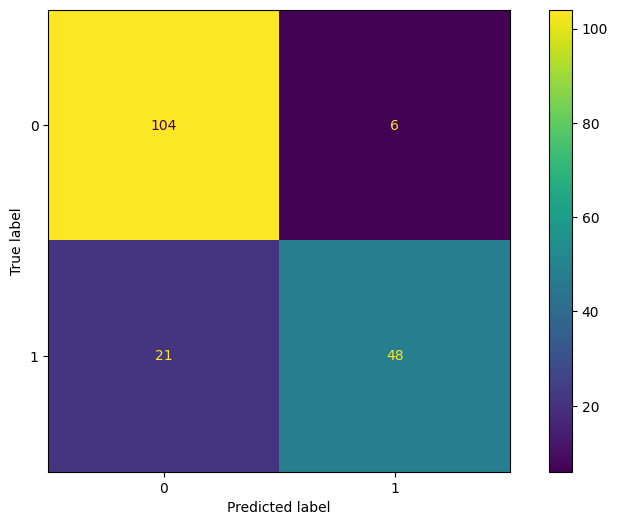

In [132]:
predictions = [0 if x < 0.55 else 1 for x in continuous_pred2.values]
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

# El backwards feature selector y mi modelo manual se parecen mucho en su performance, pero mi modelo usa menos predictores. Me quedo con el mío por parsimonia

# MODELO FINAL!

In [227]:
final_X_test = df_titanic_test.select_dtypes(exclude = object).drop(["Embarked"],axis = 1).copy()
final_X_test.Pclass = final_X_test.Pclass.astype("int")
final_X_test.Sex = final_X_test.Sex.astype("int")
final_X_test.Cantidad_MismoApellido = final_X_test.Cantidad_MismoApellido.astype("int")

final_X_test = transf_test(final_X_test,df_transformaciones_nombre)

final_X_test = pd.DataFrame(interaction.fit_transform(final_X_test), columns=interaction.get_feature_names_out(input_features=final_X_test.columns))
final_X_test = final_X_test.loc[:, final_X_test.var() != 0.0]
final_X_test.columns = [x.replace("-","_") for x in final_X_test.columns]
final_X_test.columns = [x.replace(" ","_") for x in final_X_test.columns]



In [228]:
train_set_model1 = train_set_model1.iloc[:,1:]
my_model_columns = list(train_set_model1.columns)


In [229]:
#Modelo Backwards:
""" 
features_backwards_sfs_no_interac = ['Pclass', 'Sex', 'Age', 'ParentsChildren', 'Fare', 'Cant_PersonasMismoTicket', 'Titulo_Rank', 'Titulo_Expandido_Rank', 'Cabin_Letra_Rank', 'Idioma_Rank', 'ParentsChildren-raiz4', 'Cant_PersonasMismoTicket-raiz4', 'Idioma_Rank-sqrt']
features_backwards_sfs_no_interac = [x.replace("-","_") for x in features_backwards_sfs_no_interac]
features_backwards_sfs_no_interac.append("PassengerId")
final_X_test = final_X_test[features_backwards_sfs_no_interac]
final_X_test = sm.add_constant(final_X_test)
"""



' \nfeatures_backwards_sfs_no_interac = [\'Pclass\', \'Sex\', \'Age\', \'ParentsChildren\', \'Fare\', \'Cant_PersonasMismoTicket\', \'Titulo_Rank\', \'Titulo_Expandido_Rank\', \'Cabin_Letra_Rank\', \'Idioma_Rank\', \'ParentsChildren-raiz4\', \'Cant_PersonasMismoTicket-raiz4\', \'Idioma_Rank-sqrt\']\nfeatures_backwards_sfs_no_interac = [x.replace("-","_") for x in features_backwards_sfs_no_interac]\nfeatures_backwards_sfs_no_interac.append("PassengerId")\nfinal_X_test = final_X_test[features_backwards_sfs_no_interac]\nfinal_X_test = sm.add_constant(final_X_test)\n'

In [230]:
train_entero = pd.concat([train_set,test_set], axis = 0)
Y = train_entero.Survived

train_entero = train_entero[my_model_columns]
train_entero = sm.add_constant(train_entero)
log_reg_sm_entero= sm.Logit(Y, train_entero).fit() 
#----------
my_model_columns.append("PassengerId")
final_X_test = final_X_test[my_model_columns]
final_X_test = sm.add_constant(final_X_test)


final_X_test = final_X_test.set_index("PassengerId")
final_X_test = final_X_test.sort_index()
predicciones_finales = log_reg_sm_entero.predict(final_X_test)
predicciones_finales = [round(x) for x in predicciones_finales.values]



Optimization terminated successfully.
         Current function value: 0.467404
         Iterations 6


In [233]:
final_X_test.index

Float64Index([ 892.0,  893.0,  894.0,  895.0,  896.0,  897.0,  898.0,  899.0,
               900.0,  901.0,
              ...
              1300.0, 1301.0, 1302.0, 1303.0, 1304.0, 1305.0, 1306.0, 1307.0,
              1308.0, 1309.0],
             dtype='float64', name='PassengerId', length=418)

In [234]:
Y_final = pd.read_csv("In/gender_submission.csv")
Y_final = Y_final.set_index("PassengerId").sort_index()
Y_final.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

Scores in test:
Accuracy: 0.9473684210526315
Precision: 0.891566265060241
Recall: 0.9736842105263158
F1 Score: 0.930817610062893

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       266
           1       0.89      0.97      0.93       152

    accuracy                           0.95       418
   macro avg       0.94      0.95      0.94       418
weighted avg       0.95      0.95      0.95       418



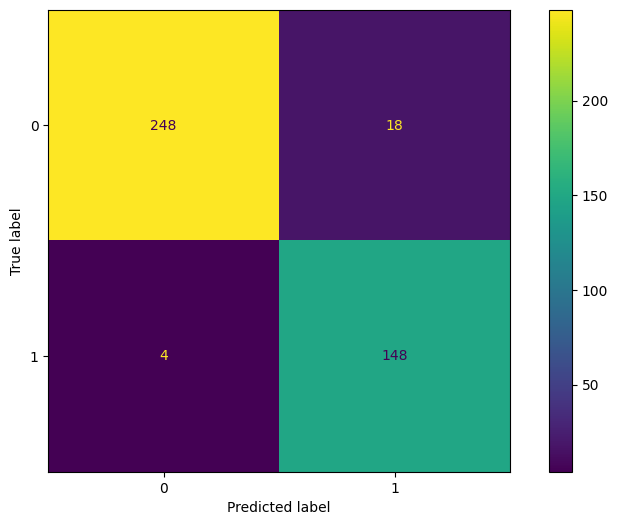

In [235]:
accuracy = accuracy_score(Y_final, predicciones_finales)
precision = precision_score(Y_final, predicciones_finales)
recall = recall_score(Y_final, predicciones_finales)
f1 = f1_score(Y_final, predicciones_finales)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_final, predicciones_finales))
cm = confusion_matrix(Y_final, predicciones_finales)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()
